# Proyecto Capstone

# 1. Extracción de datos y generación de datos sintéticos

In [ ]:
# Instalamos:
!pip install unidecode
!pip install -U openai==1.14.0
!pip install --upgrade openai

  Using cached openai-1.14.0-py3-none-any.whl.metadata (18 kB)
Using cached openai-1.14.0-py3-none-any.whl (257 kB)
  Attempting uninstall: openai
    Found existing installation: openai 2.11.0
    Uninstalling openai-2.11.0:
      Successfully uninstalled openai-2.11.0
  Using cached openai-2.11.0-py3-none-any.whl.metadata (29 kB)
Using cached openai-2.11.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: openai
    Found existing installation: openai 1.14.0
    Uninstalling openai-1.14.0:
      Successfully uninstalled openai-1.14.0


In [ ]:
# Importamos librería de manipulacion de datos
import pandas as pd
import numpy as np
import json
from math import pi

# Librerías de terceros (datos y web)
import requests
from bs4 import BeautifulSoup
from unidecode import unidecode
from openai import OpenAI

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Google Colab
from google.colab import files

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA



In [3]:
# Importamos la API key de OpenAI
import os
from google.colab import userdata

os.environ["API_KEY"] = userdata.get("API_KEY")
api_key = os.environ["API_KEY"]


## 1.1 Tabla Cursos_Immune - Web Scrapping

In [ ]:
# 1. Descargar la página de programas
url = "https://immune.institute/programas/"
html = requests.get(url).text

# 2. Enviar el HTML al modelo para que extraiga la info
system_prompt = "Actúa como un extractor experto de datos desde contenido HTML."
user_prompt = f"""
A partir del siguiente texto: {html}, recopila los 31 programas ofertados en la página devolviendo una json con las columnas:

- id_curso: Genera para cada programa un código de la forma C0001, C0002, ..., C0010, etc
- nombre: indica el nombre del programa tal cual aparece en la página
- tipo de programa: Curso, Bootcamp, Master, Especialización
- descripcion
- horas totales
- duracion: número de semanas
- modalidad
- inicio
- salidas profesionales
- financiacion
- precio: en caso de no aparecer, indica un valor aproximado
- años_ofertado: genera un número aleatorio entre 1 y 5
- sector: Software, Data Science, Cloud Computing, Ciberseguridad, UX/UI & Diseño

**IMPORTANTE**
- Devuelve solo JSON válido. Sin explicaciones.
- No puedes repetir registros
- Ten en cuenta que hay 31 programas distintos en la página
- Ignora la información que no se encuentre en el cuerpo de la página como barras laterales e índices
- Usa siempre información actualizada directamente de las páginas internas de cada programa
- Si no encuentras el precio del programa, estima un valor en función del tipo de programa, la duración, las horas y la modalidad
- Si no aparecen las horas totales, haz una estimación en función de la duración
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
)

respuesta = response.choices[0].message.content

if respuesta.startswith("```"):
    respuesta = respuesta.strip("`")           # elimina las comillas invertidas
    respuesta = respuesta.replace("json", "")  # elimina la palabra "json"
    respuesta = respuesta.replace("```", "")   # elimina cualquier otro bloque
    respuesta = respuesta.strip()

# Convertimos la respuesta a formato json
data = json.loads(respuesta)
# Convertimos json a dataframe
df_cursos = pd.DataFrame(data)

In [ ]:
df_cursos.shape
df_cursos

id_curso                                             nombre  \
0     C0001               Ingenieria de Desarrollo de Software   
1     C0002                             Máster en Data Science   
2     C0003                          Máster en Cloud Computing   
3     C0004                                     Ciberseguridad   
4     C0005                            Bootcamp Data Analytics   
5     C0006                         Bootcamp en Desarrollo Web   
6     C0007                  Máster en Inteligencia Artificial   
7     C0008              Máster Avanzado en Cloud Architecture   
8     C0009                         Bootcamp en Ciberseguridad   
9     C0010         Especialización en Inteligencia Artificial   
10    C0011                                    Curso de Python   
11    C0012                  Data Science & Business Analytics   
12    C0013                        Seguridad de la Información   
13    C0014                      Técnicas de análisis de datos   
14    C0015            Actividades extraescolares tecnológicas   
15    C0016             Inteligencia Artificial y data science   
16    C0017              Especialización en Cloud Architecture   
17    C0018                Bootcamp en Inteligencia Artificial   
18    C0019                         Bootcamp en Data Analytics   
19    C0020  Programa avanzado en IA & Data Science for Bus...   
20    C0021   Máster en Cloud Architecture y Devops Management   
21    C0022                       Bootcamp en Desarrollo React   
22    C0023                                  Bootcamp en UX/UI   
23    C0024           Maestría en Diseño UX/UI & Accesibilidad   
24    C0025              Máster en Seguridad de la Información   
25    C0026          Bootcamp en Técnicas de Análisis de Datos   
26    C0027                       Bootcamp en Análisis Forense   
27    C0028  Bootcamp de Diseño y Desarrollo de Bases de Datos   
28    C0029         Bootcamp en Desarrollo de Aplicaciones Web   
29    C0030                               Máster en Innovación   
30    C0031  Especialización en Desarrollo de Aplicaciones ...   

     tipo_de_programa                                        descripcion  \
0            Bachelor     Grado en Ingeniería de Desarrollo de Software.   
1            Maestría  Máster oficial en Data Science con enfoque prá...   
2            Maestría  Enfocado en habilidades de arquitectura en la ...   
3              Máster  Educación en defensa cibernética y protección ...   
4            Bootcamp            Cursos intensivos en análisis de datos.   
5            Bootcamp      Formación intensiva en desarrollo full stack.   
6            Maestría        Formación en técnicas y aplicaciones de IA.   
7   Maestría Avanzada    Especialización en arquitectura Cloud y devOps.   
8            Bootcamp  Ciberseguridad y prevención de brechas de segu...   
9     Especialización                  Foco en técnicas aplicadas de IA.   
10              Curso         Introducción a la programación con Python.   
11           Maestría  Máster enfocado en el análisis de datos aplica...   
12           Maestría           Máster oficial en seguridad informática.   
13              Curso  Formación en herramientas de análisis y visual...   
14     Extraescolares         Introducción a la tecnología para jóvenes.   
15  Maestría Avanzada        Máster que une IA y desarrollo de negocios.   
16    Especialización          Formación avanzada en arquitectura Cloud.   
17           Bootcamp          Intensivo en habilidades prácticas de IA.   
18           Bootcamp       Capacitación intensiva en análisis de datos.   
19  Programa Avanzado          Foco en implementación de IA en negocios.   
20  Maestría Avanzada  Formación avanzada en desarrollo e implementac...   
21           Bootcamp  Educación intensiva en desarrollo de aplicacio...   
22           Bootcamp  Intensivo en diseño de interfaces y experienci...   
23           Maestría  Enfoque en accesibilidad y diseño centrado 

In [ ]:
# Descargamos el fichero
df_cursos.to_excel("cursos_immune.xlsx", index=False)
files.download("cursos_immune.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 1.2 Tabla Formularios (Sintética)

In [ ]:
user_prompt = """
Devuelve un JSON de 300 registros sin texto adicional que represente los datos que introduce una persona al registrarse en una página de formación.
Cada registro debe contener las siguientes columnas y cumplir todas las reglas de coherencia indicadas más abajo:

** Columnas:

id_usuario (valor único, no repetido)

Ciudad

País (debe concordar con la ciudad)

Edad (entre 18 y 55 años)

Género (Hombre, Mujer, No contesta)

Área de interés para formarse

Titulación académica

Área de estudios

Experiencia laboral (años)

Sector laboral

Motivo de la formación

** Reglas de coherencia obligatorias:

Relación Ciudad ↔ País (coherencia geográfica)
Usa combinaciones reales, por ejemplo:

España → Madrid, Barcelona, Valencia, Sevilla, Bilbao

México → México DF, Guadalajara, Monterrey

Colombia → Bogotá, Medellín

Argentina → Buenos Aires, Córdoba

Chile → Santiago, Valparaíso

Perú → Lima, Arequipa

Relación Titulación ↔ Área de estudios
Si la titulación es:

ESO o Bachillerato → Área de estudios = “Estudios obligatorios” Si es cualquier otra titulación (FP, Grado, Máster, Doctorado):

Elige un área de estudios coherente: Informática, Ingeniería, Matemáticas, Física, Diseño, ADE, Comunicación, Ciencias Sociales.

Relación Edad ↔ Experiencia laboral
La experiencia debe ser realista respecto a la edad:

18–22 años → 0 a 3 años de experiencia

23–30 años → 1 a 8 años

31–40 años → 3 a 20 años

41–65 años → 5 a 40 años

Relación Experiencia ↔ Motivo de la formación
Si la experiencia laboral es 0 años:

Motivos posibles: “Ampliar conocimiento”, “Búsqueda de empleo” (no puede ser “Cambio de trabajo”)

Si la experiencia es > 0 años:

Motivos posibles: “Cambio de trabajo”, “Ampliar conocimiento”, “Escalar en el trabajo”, “Búsqueda de empleo”

Otras reglas
El id_usuario debe tener un formato tipo U0001, U0002…

Los datos deben ser coherentes en conjunto.
Debes devolver 300 registros.

"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": user_prompt}
    ]
)

respuesta = response.choices[0].message.content

if respuesta.startswith("```"):
    respuesta = respuesta.strip("`")           # elimina las comillas invertidas
    respuesta = respuesta.replace("json", "")  # elimina la palabra "json"
    respuesta = respuesta.replace("```", "")   # elimina cualquier otro bloque
    respuesta = respuesta.strip()

# Convertimos la respuesta a formato json
data = json.loads(respuesta)
# Convertimos json a dataframe
df_formulario = pd.DataFrame(data)

In [ ]:
# Descargamos el fichero
df_formulario.to_excel("formularios.xlsx", index=False)

files.download("formularios.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

A partir de esta plantilla hemos generado 700 registros más usando la herramienta XXXXX

## 1.3 Tabla Feedbacks  (Sintética)

In [ ]:
# Extraemos el nombre de los cursos y sus ids de Cursos Immune
id_curso_nombre = pd.read_excel("cursos_immune.xlsx")[["id_curso","nombre"]]
print(id_curso_nombre)

   id_curso                                             nombre
0     C0001               Ingenieria de Desarrollo de Software
1     C0002                             Máster en Data Science
2     C0003                          Máster en Cloud Computing
3     C0004                                     Ciberseguridad
4     C0005                            Bootcamp Data Analytics
5     C0006                         Bootcamp en Desarrollo Web
6     C0007                  Máster en Inteligencia Artificial
7     C0008              Máster Avanzado en Cloud Architecture
8     C0009                         Bootcamp en Ciberseguridad
9     C0010         Especialización en Inteligencia Artificial
10    C0011                                    Curso de Python
11    C0012                  Data Science & Business Analytics
12    C0013                        Seguridad de la Información
13    C0014                      Técnicas de análisis de datos
14    C0015            Actividades extraescolares tecno

In [ ]:
system_prompt = f"En el siguiente dataset se muestran los programas ofertados en una página web con sus respectivos ids: {id_curso_nombre}"

user_prompt = """
Devuelve un JSON con las siguientes columnas:

** Columnas:

- fecha: en formato fecha y hora
- id_programa: utiliza los ids indicados anteriormente
- preparado_clases: 1,2,3,4 o 5
- dominio_materia: 1,2,3,4 o 5
- mantiene_atencion: 1,2,3,4 o 5
- relaciona_con_ejemplos: 1,2,3,4 o 5
- ejemplos_mundo_profesional: 1,2,3,4 o 5
- accesible_y_atiende_consultas: 1,2,3,4 o 5
- fomenta_colaboracion: 1,2,3,4 o 5
- puntualidad: 1,2,3,4 o 5
- referencias_en_redes: 1,2,3,4 o 5
- recomendaria_profesor: 1,2,3,4 o 5
- organiza_actividades: 1,2,3,4 o 5
- contenidos_adecuados: 1,2,3,4 o 5
- grado_dificultad: 1,2,3,4 o 5
- conocimientos_utiles_futuro: Pésimo, Mal, Regular, Bien o Genial
- clase_duracion: Pésimo, Mal, Regular, Bien o Genial
- clase_horario: Pésimo, Mal, Regular, Bien o Genial
- clase_conveniencia_dia: Pésimo, Mal, Regular, Bien o Genial
- clase_calidad_conexion: Pésimo, Mal, Regular, Bien o Genial
- clase_visibilidad_pantalla: Pésimo, Mal, Regular, Bien o Genial
- clase_calidad_audio: Pésimo, Mal, Regular, Bien o Genial
- velocidad_respuesta: Pésimo, Mal, Regular, Bien o Genial
- utilidad_anuncios: Pésimo, Mal, Regular, Bien o Genial
- satisfaccion_general: Pésimo, Mal, Regular, Bien o Genial
- tipo_programa: online, presencial o ambos
- comentarios: genera una opinión del alumno sobre el programa que sea coherente con la puntuación indicada en el resto de campos. Puede haber registros con comentarios nulos.

Importante:
* Devuelve solamente un JSON con el mayor número posible de registros del json y no incluyas texto adicional
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
)

respuesta = response.choices[0].message.content

if respuesta.startswith("```"):
    respuesta = respuesta.strip("`")           # elimina las comillas invertidas
    respuesta = respuesta.replace("json", "")  # elimina la palabra "json"
    respuesta = respuesta.replace("```", "")   # elimina cualquier otro bloque
    respuesta = respuesta.strip()

# Convertimos la respuesta a formato json
data_feedbacks = json.loads(respuesta)
# Convertimos json a dataframe
df_feedback = pd.DataFrame(data_feedbacks)

In [ ]:
# Descargamos el fichero
df_feedback .to_excel("feedbacks.xlsx", index=False)

files.download("feedbacks.xlsx")

# 2. Analisis de datos

## 2.1 Immune_metricas.csv

In [ ]:
# Exportamos los datos
immune = pd.read_csv("Immune_metricas.csv")
print(immune.shape)
immune.head()

#immune["Id_usuario"].replace("U000","U00700")

(5000, 10)


usuario_temp origen_plataforma      IP_usuario  tiempo_en_pagina  \
0  TEMP_000001            Google    45.213.75.93                68   
1  TEMP_000002          LinkedIn     163.72.1.82                60   
2  TEMP_000003          LinkedIn  175.108.182.18               193   
3  TEMP_000004        Google Ads    66.60.16.165                60   
4  TEMP_000005         Instagram   54.120.253.63               502   

            fecha_hora       Localizacion programa_oferta_click Id_usuario  \
0  2024-03-03 11:46:25  Barcelona, España                 C0011        NaN   
1  2025-08-23 15:12:05     Málaga, España                 C0014      U0202   
2  2025-01-03 16:58:43  Valparaíso, Chile                 C0019      U0630   
3  2025-07-03 07:50:27   Zaragoza, España                 C0015        NaN   
4  2024-12-15 19:22:46  Barcelona, España                 C0001        NaN   

  Dispositivo  Matriculado  
0      mobile        False  
1      tablet        False  
2      mobile        False  
3     desktop        False  
4      mobile        False

In [ ]:
# Analizamos tipo de variables
immune.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   usuario_temp           5000 non-null   object
 1   origen_plataforma      5000 non-null   object
 2   IP_usuario             5000 non-null   object
 3   tiempo_en_pagina       5000 non-null   int64 
 4   fecha_hora             5000 non-null   object
 5   Localizacion           5000 non-null   object
 6   programa_oferta_click  4064 non-null   object
 7   Id_usuario             906 non-null    object
 8   Dispositivo            5000 non-null   object
 9   Matriculado            5000 non-null   bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 356.6+ KB


In [ ]:
## Primeros pasos:
# Cambiamos nombre de las columnas a minusculas
immune.columns = immune.columns.str.lower()
# 1. Modificamos el tipo de la columna fecha_hora:
immune["fecha_hora"] = pd.to_datetime(immune["fecha_hora"])
# 2. Separamos la columna localizacion en pais y ciudad
immune["ciudad"] = immune["localizacion"].str.split(",").str[0].str.strip()
immune["pais"] = immune["localizacion"].str.split(",").str[1].str.strip()
# 3. Extraemos el Año, Mes, Dia, Dia de la semana, Hora y las convertimos a texto
immune["año"] = immune["fecha_hora"].dt.year.astype(str)
immune["mes"] = immune["fecha_hora"].dt.month.astype(str).str.zfill(2)
immune["dia"] = immune["fecha_hora"].dt.day.astype(str).str.zfill(2)
immune["dia_semana"] = immune["fecha_hora"].dt.weekday.astype(str)
  # Devuelve 0 si es lunes y 6 si es domingo
immune["hora"] = immune["fecha_hora"].dt.hour.astype(str).str.zfill(2)


In [ ]:
# Analizamos variables numéricas
immune["tiempo_en_pagina"].describe()

count    5000.000000
mean      256.788000
std       241.654914
min        10.000000
25%        62.000000
50%       165.000000
75%       366.250000
max       900.000000
Name: tiempo_en_pagina, dtype: float64

La media de tiempo en la página de Immune es de 256 sg con una desviación de 241 sg. El 60% de los registros se situará en torno a 62 - 360 segundos que corresponde al primer y tercer cuartil. Se observa gran diferencia entre el máximo y el mínimo por lo que es posible que haya outliers por encima del tercer quartil. Veamos su distribución

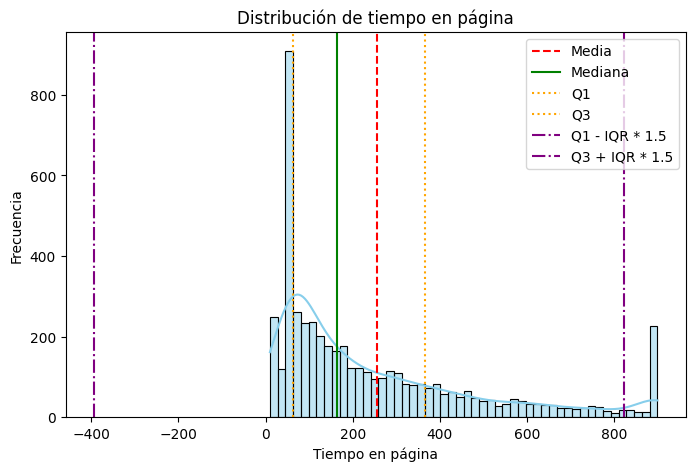

In [ ]:
data = immune["tiempo_en_pagina"]
# Cálculos estadísticos
mean = data.mean()
median = data.median()
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Crear figura y eje
fig, ax = plt.subplots(figsize=(8,5))

# Histograma con KDE
sns.histplot(data, bins=50, kde=True, color='skyblue', ax=ax)

# Líneas verticales
ax.axvline(mean, color='red', linestyle='--', label='Media')
ax.axvline(median, color='green', linestyle='-', label='Mediana')
ax.axvline(q1, color='orange', linestyle=':', label='Q1')
ax.axvline(q3, color='orange', linestyle=':', label='Q3')
ax.axvline(lower, color='purple', linestyle='-.', label='Q1 - IQR * 1.5')
ax.axvline(upper, color='purple', linestyle='-.', label='Q3 + IQR * 1.5')

# Configuración de leyenda, etiquetas y título
ax.legend()
ax.set_xlabel('Tiempo en página')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de tiempo en página', fontsize=12)
ax.tick_params(axis='both', labelsize=10)

plt.show()

En la gráfica se observa que no hay registros de tiempo negativo y se confirma también la existencia de outliers por encima de 800 sg. También se observa muchos registros que permanecen en la página 1 min.

In [ ]:
immune.select_dtypes(include=["object"]).describe()

usuario_temp origen_plataforma     ip_usuario    localizacion  \
count          5000              5000           5000            5000   
unique         5000                 4           4293              26   
top     TEMP_005000          LinkedIn  75.212.209.74  Bilbao, España   
freq              1              1492              6             418   

       programa_oferta_click id_usuario dispositivo  ciudad    pais   año  \
count                   4064        906        5000    5000    5000  5000   
unique                    31        700           3      26       9     2   
top                    C0023      U0246      mobile  Bilbao  España  2024   
freq                     163          6        2697     418    2583  2644   

         mes   dia dia_semana  hora  
count   5000  5000       5000  5000  
unique    12    31          7    24  
top       05    04          5    13  
freq     464   183        759   399

Analizandos las variables cualitativas, observamos que el usuario temporal asignado a cada búsqueda en las páginas de Immune no se repite aunque sí hay registros desde el mismo ip. Los usuarios pueden acceder desde 4 fuentes distintas  y mediante 3 tipos de dispositivos. Tenemos registros de 9 países diferentes y un total de 26 ciudades.

La columna programa_oferta_click indica si el usuario ha clicado en uno de los 31 programas ofertados. Los registros nulos indican sesiones en las que no se ha interesado por un programa.

Con las columnas añadidas a partir de fecha, vemos que tenemos registros de dos años, que abarcan los 12 meses y todos los días de la semana. Siendo cuando más consultas se hacen los sábados y la hora de mayor consulta a las 13h.

In [ ]:
# Para separar las visitas que generan curiosidad en los programas de las que no generarmos una nueva columna que sea 0 si el valor de programa_oferta_click es nulo y 1 en caso contarrio
immune["solicita_informacion"] = np.where(immune["programa_oferta_click"].isnull(),0,1)

/tmp/ipython-input-797446987.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=immune, x=var, order=order, palette='pastel', ax=ax)
/tmp/ipython-input-797446987.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=immune, x=var, order=order, palette='pastel', ax=ax)
/tmp/ipython-input-797446987.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=immune, x=var, order=order, palette='pastel', ax=ax)
/tmp/ipython-input-797446987.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be 

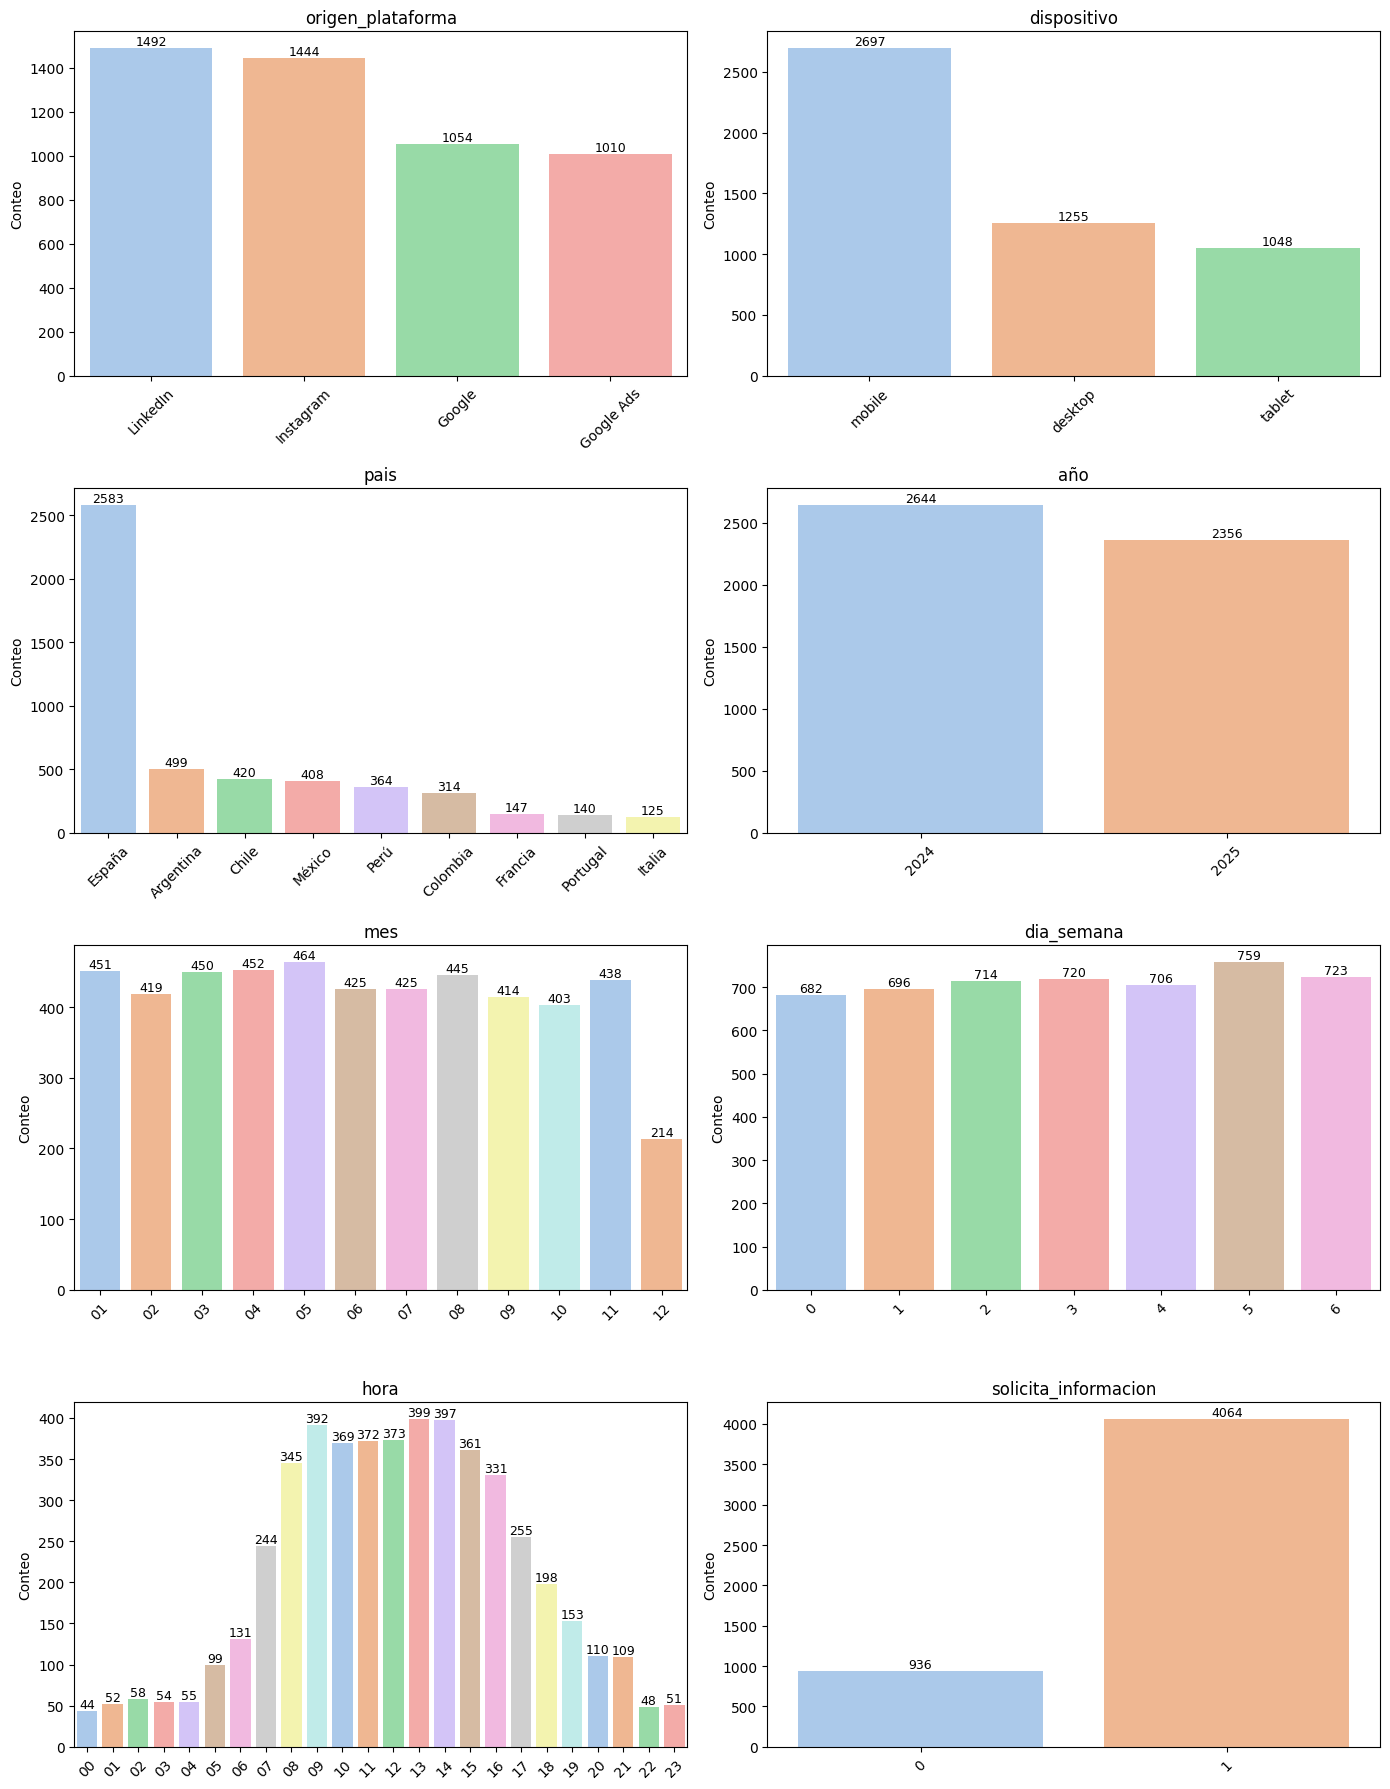

In [ ]:
# Lista de variables a analizar
variables_analizar = ["origen_plataforma","dispositivo","pais","año","mes","dia_semana","hora","solicita_informacion"]

# Crear figura con 4 filas y 2 columnas
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 18))
axes = axes.flatten()

# Iterar sobre variables y ejes
for i, var in enumerate(variables_analizar):
    ax = axes[i]

    # Orden por frecuencia por defecto
    order = immune[var].value_counts().index

    # Para estas variables, ordenar alfabéticamente
    if var in ["mes","dia_semana","hora","solicita_informacion"]:
        order = sorted(immune[var].unique())

    sns.countplot(data=immune, x=var, order=order, palette='pastel', ax=ax)
    ax.set_title(var, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Conteo')
    ax.tick_params(axis='x', rotation=45)

    # Mostrar total encima de cada barra
    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

In [ ]:
# Descargamos la nueva tabla immune para trabajar en PBI
immune.to_excel("Immune_metricas_PBI.xlsx", index=False)

files.download("Immune_metricas_PBI.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2.2 Tabla Formularios.xlsx

In [ ]:
# Importamos los datos
formulario = pd.read_excel("formularios.xlsx")
print(formulario.shape)
formulario.head()

(700, 11)


id_usuario       Ciudad    País  Edad       Género  \
0      U0001       Madrid  España    40       Hombre   
1      U0002    Barcelona  España    29        Mujer   
2      U0003  Guadalajara  México    23  No contesta   
3      U0004     Santiago   Chile    24        Mujer   
4      U0005         Lima    Perú    35       Hombre   

  Área de interés para formarse Titulación académica       Área de estudios  \
0                   Informática                Grado            Informática   
1                        Diseño               Máster                 Diseño   
2                  Comunicación         Bachillerato  Estudios obligatorios   
3             Ciencias Sociales            Doctorado      Ciencias Sociales   
4                   Matemáticas                Grado            Matemáticas   

   Experiencia laboral                 Sector laboral Motivo de la formación  
0                    3  Tecnologías de la información  Escalar en el trabajo  
1                    5                 Diseño gráfico      Cambio de trabajo  
2                    1                   Comunicación     Búsqueda de empleo  
3                    6                  Investigación   Ampliar conocimiento  
4                   10                      Educación  Escalar en el trabajo

In [ ]:
formulario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   id_usuario                     700 non-null    object
 1   Ciudad                         700 non-null    object
 2   País                           700 non-null    object
 3   Edad                           700 non-null    int64 
 4   Género                         700 non-null    object
 5   Área de interés para formarse  700 non-null    object
 6   Titulación académica           700 non-null    object
 7   Área de estudios               700 non-null    object
 8   Experiencia laboral            700 non-null    int64 
 9   Sector laboral                 700 non-null    object
 10  Motivo de la formación         700 non-null    object
dtypes: int64(2), object(9)
memory usage: 60.3+ KB


In [ ]:
# En primer lugar, quitaremos las tildes de los nombres de las columnas, las dejaremos en minúsculas y sustituiremos los espacios por "_"
formulario.columns = [unidecode(col.lower().replace(" ","_")) for col in formulario.columns]

In [ ]:
formulario.select_dtypes("number").describe()

edad  experiencia_laboral
count  700.000000           700.000000
mean    29.778571             6.310000
std      8.146080             6.108899
min     18.000000             0.000000
25%     23.000000             1.000000
50%     29.000000             5.000000
75%     36.000000            10.000000
max     50.000000            29.000000

Se observa que la media de edad de los usuarios ronda los 30 años con una desviación de 8 por lo que la mayoría de registros se encontrarán entre los 22 y los 38. El mínimo de edad registrado es 18 y el máximo 50 por lo que es posible que encontremos outliers por encima en la distribución.

Respecto a la experiencia laboral, la media es de 6 años aunque el rango de esta variable está entre los 0 años y 29. Es posible que encontremos outliers por encima.



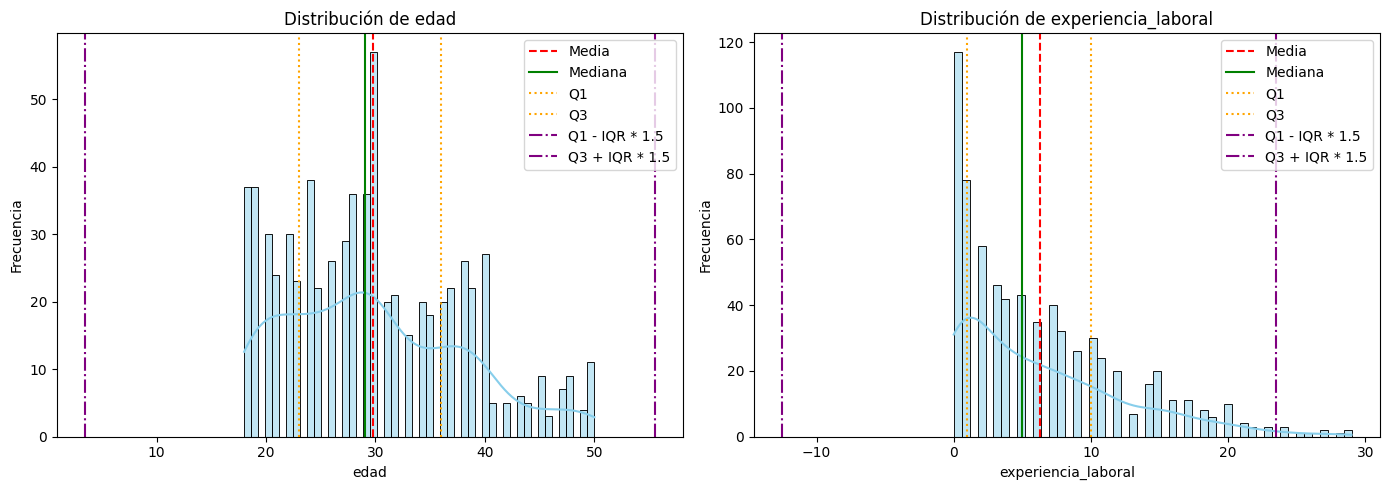

In [ ]:
# Representamos las distribuciones de las variables numéricas:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, col in enumerate(["edad", "experiencia_laboral"]):
    data = formulario[col]  # <-- ahora graficamos cada columna correctamente

    # Cálculos estadísticos
    mean = data.mean()
    median = data.median()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    ax = axes[i]  # asignamos cada gráfico a un subplot diferente

    # Histograma con KDE
    sns.histplot(data, bins=50, kde=True, color='skyblue', ax=ax)

    # Líneas verticales
    ax.axvline(mean, color='red', linestyle='--', label='Media')
    ax.axvline(median, color='green', linestyle='-', label='Mediana')
    ax.axvline(q1, color='orange', linestyle=':', label='Q1')
    ax.axvline(q3, color='orange', linestyle=':', label='Q3')
    ax.axvline(lower, color='purple', linestyle='-.', label='Q1 - IQR * 1.5')
    ax.axvline(upper, color='purple', linestyle='-.', label='Q3 + IQR * 1.5')

    # Configuración de leyenda, etiquetas y título
    ax.legend()
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Distribución de {col}', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()  # Ajusta espacios entre subplots
plt.show()

La variable edad no tiene outliers y vemos que hay más registros con edades entre 18 y 30 que entre 30 y 50.

En la experiencia laboral, vemos cómo disminuye el número de registros cuanto más aumenta la experiencia. Destaca mucho el número de registros sin experiencia y se confirma la existencia de outliers por la derecha.

153  registros con experiencia laboral por encima de:  10.0 años:


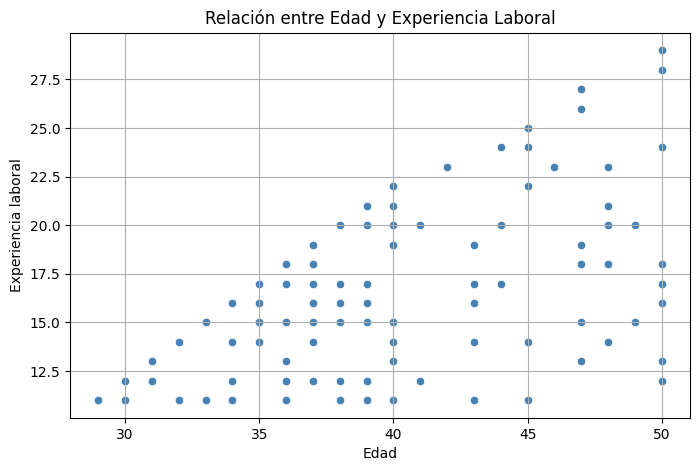

In [ ]:
# Revisamos autovalores comparando con la edad del registro
q1 = formulario["experiencia_laboral"].quantile(0.75)
q3 = formulario["experiencia_laboral"].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
outliers = formulario[formulario["experiencia_laboral"] > upper][["edad","experiencia_laboral"]]
print(len(outliers), " registros con experiencia laboral por encima de: ", upper, "años:")
plt.figure(figsize=(8,5))

sns.scatterplot(
    data=outliers,
    x="edad",
    y="experiencia_laboral",
    color="steelblue"
)

plt.title("Relación entre Edad y Experiencia Laboral")
plt.xlabel("Edad")
plt.ylabel("Experiencia laboral")
plt.grid(True)

plt.show()

Tiene sentido que las personas con mayor experiencia laboral se encuentren en el rango de edad entre 30 y 50 y la gráfica crece de forma lineal por lo que no hay que eliminar outliers

In [ ]:
formulario.select_dtypes("object").describe()

id_usuario   ciudad       pais genero area_de_interes_para_formarse  \
count         700      700        700    700                           700   
unique        700       18          8      3                            11   
top         U0700  Córdoba  Argentina  Mujer             Ciencias Sociales   
freq            1       87        159    291                           152   

       titulacion_academica       area_de_estudios sector_laboral  \
count                   700                    700            700   
unique                    5                     10             16   
top                   Grado  Estudios obligatorios    Estudiantes   
freq                    252                    155            129   

       motivo_de_la_formacion  
count                     700  
unique                      4  
top      Ampliar conocimiento  
freq                      190

/tmp/ipython-input-3730566433.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=formulario, x=col, ax=axes[i], palette="Set2")
/tmp/ipython-input-3730566433.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=formulario, x=col, ax=axes[i], palette="Set2")
/tmp/ipython-input-3730566433.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=formulario, x=col, ax=axes[i], palette="Set2")
/tmp/ipython-input-3730566433.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0

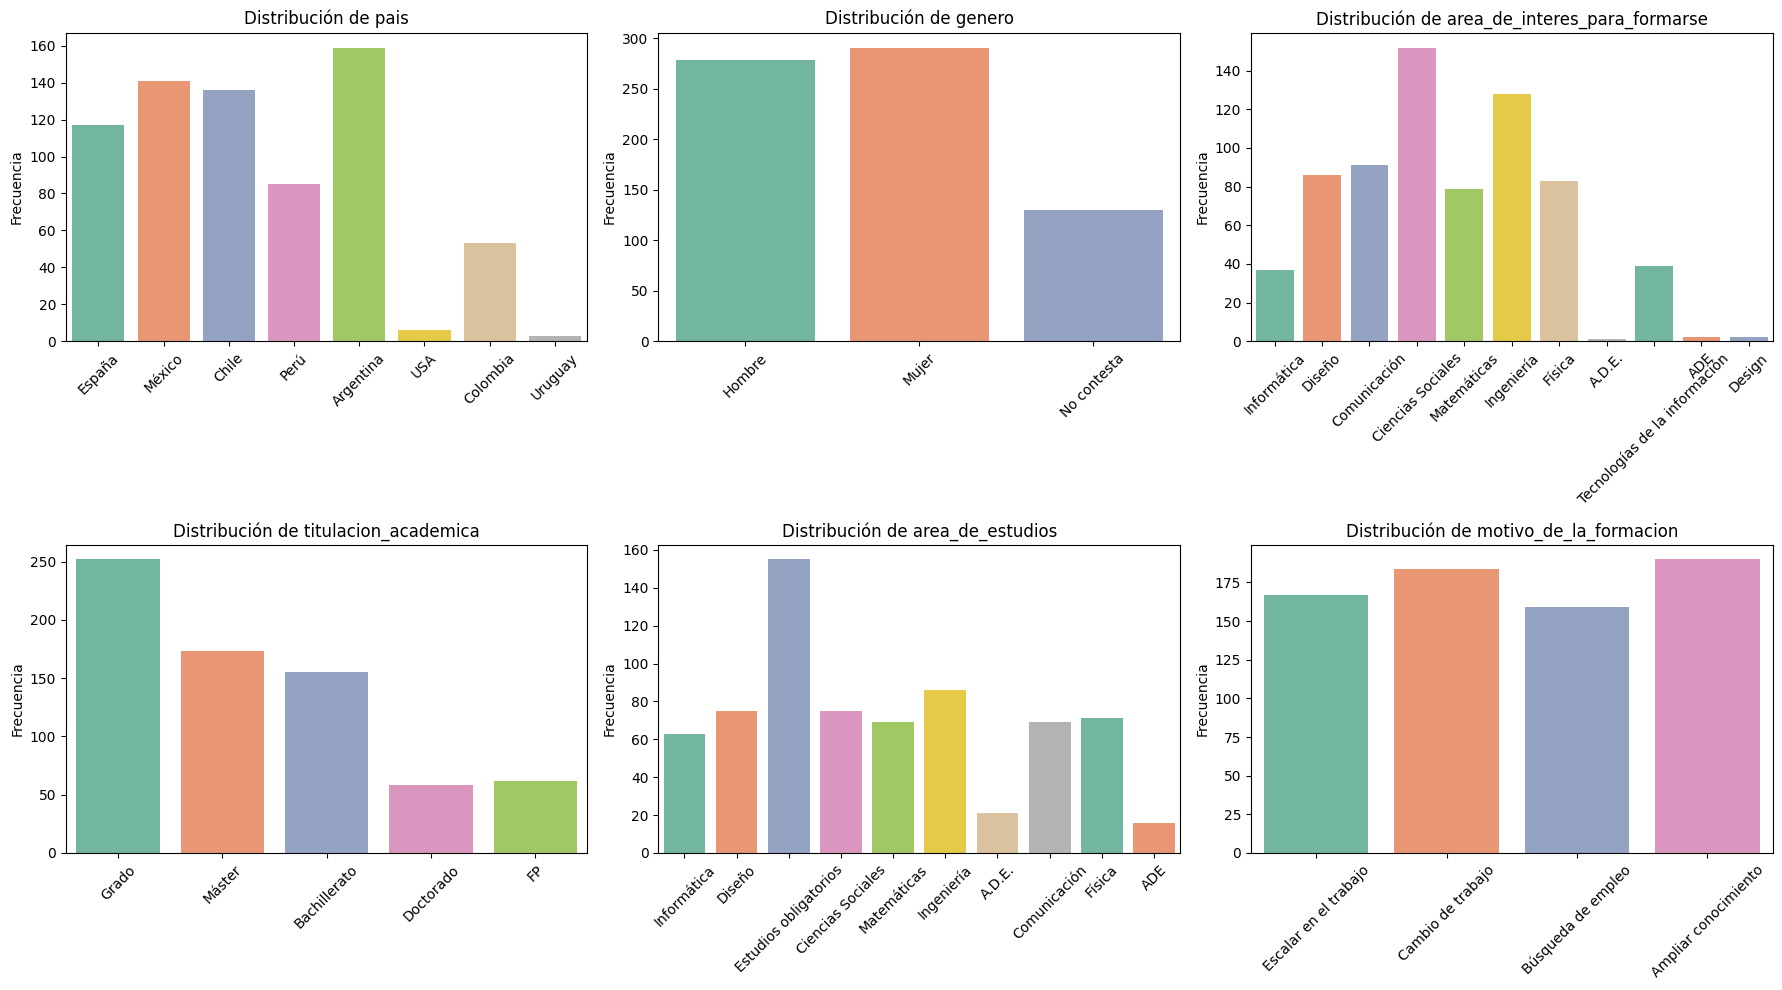

In [ ]:
variables = ["pais","genero","area_de_interes_para_formarse",	"titulacion_academica","area_de_estudios","motivo_de_la_formacion"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 filas x 3 columnas
axes = axes.flatten()  # aplanamos para iterar más fácil

for i, col in enumerate(variables):
    sns.countplot(data=formulario, x=col, ax=axes[i], palette="Set2")
    axes[i].set_title(f"Distribución de {col}", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)  # inclinamos etiquetas
    axes[i].set_xlabel("")  # quitamos etiqueta para estética
    axes[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [ ]:
# Ajustamos valores del dataset que representan la misma categoría pero con distinto nombre
formulario["area_de_estudios"] = formulario["area_de_estudios"].replace("A.D.E.","ADE")
formulario["area_de_interes_para_formarse"] = formulario["area_de_interes_para_formarse"].replace("A.D.E.","ADE")
formulario["area_de_interes_para_formarse"] = formulario["area_de_interes_para_formarse"].replace("Design","Diseño")

/tmp/ipython-input-2755007508.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=formulario, x="sector_laboral", palette="Set2")


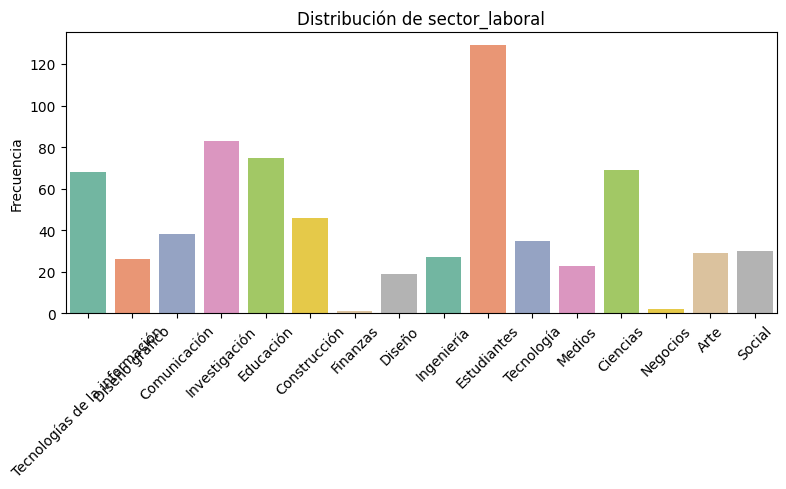

In [ ]:
plt.figure(figsize=(8,5))

sns.countplot(data=formulario, x="sector_laboral", palette="Set2")

plt.title("Distribución de sector_laboral", fontsize=12)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [ ]:
formulario.to_excel("formularios_PBI.xlsx", index=False)

files.download("formularios_PBI.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2.3 Tabla Feedbacks.csv

In [ ]:
feedback = pd.read_csv("Feedbacks.csv")
feedback.head(10)

Id_encuesta id_usuario Id_curso Tipo_clase                fecha  \
0       E0001      U1179    C0001    Híbrido  2023-01-05 19:05:05   
1       E0002      U0866    C0009    Híbrido  2023-01-06 08:31:27   
2       E0003      U0102    C0018    Híbrido  2023-01-06 19:28:11   
3       E0004      U0440    C0001    Híbrido  2023-01-06 22:41:45   
4       E0005      U0059    C0017     Online  2023-01-06 23:50:24   
5       E0006      U1121    C0016     Online  2023-01-08 03:06:35   
6       E0007      U0324    C0010     Online  2023-01-08 17:57:17   
7       E0008      U0975    C0018    Híbrido  2023-01-09 00:13:26   
8       E0009      U0412    C0017     Online  2023-01-09 01:28:49   
9       E0010      U0856    C0024     Online  2023-01-09 14:23:37   

   preparado_clases  dominio_materia  mantiene_atencion  \
0                 5                4                  3   
1                 2                4                  5   
2                 3                2                  3   
3                 4                5                  2   
4                 1                2                  2   
5                 2                1                  5   
6                 5                2                  5   
7                 5                4                  4   
8                 2                3                  5   
9                 4                5                  5   

   relaciona_con_ejemplos  ejemplos_mundo_profesional  ...  clase_duracion  \
0                       4                           4  ...             Mal   
1                       5                           2  ...          Genial   
2                       3                           1  ...          Pésimo   
3                       2                           3  ...            Bien   
4                       2                           4  ...         Regular   
5                       1                           2  ...            Bien   
6                       5                           4  ...          Genial   
7                       4                           4  ...          Genial   
8                       3                           1  ...          Pésimo   
9                       4                           5  ...            Bien   

   clase_horario  clase_conveniencia_dia  clase_calidad_conexion  \
0         Genial                 Regular                    Bien   
1        Regular                  Genial                 Regular   
2         Pésimo                  Pésimo                     Mal   
3           Bien                  Genial                  Pésimo   
4         Pésimo                  Pésimo                  Pésimo   
5         Genial                  Genial                  Genial   
6         Genial                    Bien                  Genial   
7         Pésimo                 Regular                  Genial   
8         Genial                  Pésimo                  Pésimo   
9         Pésimo                  Genial                 Regular   

   clase_visibilidad_pantalla  clase_calidad_audio  velocidad_respuesta  \
0                      Genial               Genial                    5   
1                     Regular               Genial                    5   
2                     Regular                  Mal                    1   
3                        Bien              Regular                    4   
4                         Mal                  Mal                    2   
5                     Regular                 Bien                    3   
6                      Genial                 Bien                    5   
7                      Genial               Genial                    4   
8                      Pésimo                 Bien                    3   
9                         Mal               Genial                    5   

   utilidad_anuncios  satisfaccion_general  \
0                  4                     2   
1                  2                     3   
2                  1

In [ ]:
feedback.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Id_encuesta                    1200 non-null   object
 1   id_usuario                     1200 non-null   object
 2   Id_curso                       1200 non-null   object
 3   Tipo_clase                     1200 non-null   object
 4   fecha                          1200 non-null   object
 5   preparado_clases               1200 non-null   int64 
 6   dominio_materia                1200 non-null   int64 
 7   mantiene_atencion              1200 non-null   int64 
 8   relaciona_con_ejemplos         1200 non-null   int64 
 9   ejemplos_mundo_profesional     1200 non-null   int64 
 10  accesible_y_atiende_consultas  1200 non-null   int64 
 11  fomenta_colaboracion           1200 non-null   int64 
 12  puntualidad                    1200 non-null   int64 
 13  ref

Analizamos los distintos valores de las columnas numéricas:

In [ ]:
for col in feedback.select_dtypes(include=['number']):
  print(col +":\n")
  print(feedback[col].value_counts())

preparado_clases:

preparado_clases
5    388
4    384
3    196
2    133
1     99
Name: count, dtype: int64
dominio_materia:

dominio_materia
4    398
5    395
3    190
2    127
1     90
Name: count, dtype: int64
mantiene_atencion:

mantiene_atencion
4    399
5    370
3    221
2    119
1     91
Name: count, dtype: int64
relaciona_con_ejemplos:

relaciona_con_ejemplos
5    419
4    378
3    180
2    118
1    105
Name: count, dtype: int64
ejemplos_mundo_profesional:

ejemplos_mundo_profesional
4    392
5    379
3    208
2    117
1    104
Name: count, dtype: int64
accesible_y_atiende_consultas:

accesible_y_atiende_consultas
4    421
5    370
3    200
2    122
1     87
Name: count, dtype: int64
fomenta_colaboracion:

fomenta_colaboracion
5    396
4    376
3    213
2    120
1     95
Name: count, dtype: int64
puntualidad:

puntualidad
5    399
4    388
3    203
2    109
1    101
Name: count, dtype: int64
referencias_en_redes:

referencias_en_redes
4    357
3    286
5    255
2    164
1    138

Analizamos los distintos valores de las columnas categóricas usadas en las métricas:

In [ ]:
columnas = ["Tipo_clase","clase_duracion","clase_horario","clase_conveniencia_dia","clase_calidad_conexion","clase_visibilidad_pantalla","clase_calidad_audio"]

for col in columnas:
  print(col +":\n")
  print(feedback[col].value_counts())

Tipo_clase:

Tipo_clase
Online     861
Híbrido    339
Name: count, dtype: int64
clase_duracion:

clase_duracion
Genial     395
Bien       379
Regular    218
Mal        117
Pésimo      91
Name: count, dtype: int64
clase_horario:

clase_horario
Genial     398
Bien       385
Regular    178
Mal        151
Pésimo      88
Name: count, dtype: int64
clase_conveniencia_dia:

clase_conveniencia_dia
Bien       394
Genial     365
Regular    224
Mal        118
Pésimo      99
Name: count, dtype: int64
clase_calidad_conexion:

clase_calidad_conexion
Bien       355
Genial     323
Regular    246
Mal        161
Pésimo     115
Name: count, dtype: int64
clase_visibilidad_pantalla:

clase_visibilidad_pantalla
Genial     396
Bien       375
Regular    204
Mal        130
Pésimo      95
Name: count, dtype: int64
clase_calidad_audio:

clase_calidad_audio
Bien       388
Genial     384
Regular    221
Mal        110
Pésimo      97
Name: count, dtype: int64


Observamos que las columnas que miden métricas de tipo texto tienen las mismas opciones a elegir (Pésimo, Mal, Regular, Bien y Genial). Convertiremos estas variables a número sustiuyéndolos por valores de 1 a 5 siendo 1 Pésimo y 5 Genial para mantener la estructura de las columnas numéricas y poder calcular medias más adelante.

In [ ]:
texto_a_numero = ["clase_duracion","clase_horario","clase_conveniencia_dia","clase_calidad_conexion","clase_visibilidad_pantalla","clase_calidad_audio"]
for col in texto_a_numero:
  feedback[col] = feedback[col].replace({
    "Pésimo": 1,
    "Mal": 2,
    "Regular": 3,
    "Bien": 4,
    "Genial": 5})


/tmp/ipython-input-2059822061.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feedback[col] = feedback[col].replace({


Por último podemos calcular una columna de puntuación media

In [ ]:
feedback["media_puntuacion"] = round(feedback.select_dtypes(include="number").mean(axis=1),2)

Para hacer varios análisis necesitaremos extraer el año de la encuesta y la edición del curso. Supondremos que en cada año se realizan dos ediciones, una comprendida entre los meses de Octubre a Marzo y otra de Abril a Septiembre.

Observación: Con datos reales no tendríamos problema para identificar las ediciones porque sabemos que a cada alumno se le incluye en un grupo de discord cuyo código combina la fecha de inicio del programa con el nombre del programa por lo que relacionando este código con el id_usuario estaría resuelto

In [ ]:
# Damos formato fecha a la columna del dataset:
feedback["fecha"] = pd.to_datetime(feedback["fecha"])
feedback["año"] = feedback["fecha"].dt.year
feedback["edicion"] = np.where(feedback["fecha"].dt.month.isin([10, 11, 12, 1, 2, 3]), 1, 2)
feedback.head()

Id_encuesta id_usuario Id_curso Tipo_clase               fecha  \
0       E0001      U1179    C0001    Híbrido 2023-01-05 19:05:05   
1       E0002      U0866    C0009    Híbrido 2023-01-06 08:31:27   
2       E0003      U0102    C0018    Híbrido 2023-01-06 19:28:11   
3       E0004      U0440    C0001    Híbrido 2023-01-06 22:41:45   
4       E0005      U0059    C0017     Online 2023-01-06 23:50:24   

   preparado_clases  dominio_materia  mantiene_atencion  \
0                 5                4                  3   
1                 2                4                  5   
2                 3                2                  3   
3                 4                5                  2   
4                 1                2                  2   

   relaciona_con_ejemplos  ejemplos_mundo_profesional  ...  \
0                       4                           4  ...   
1                       5                           2  ...   
2                       3                           1  ...   
3                       2                           3  ...   
4                       2                           4  ...   

   clase_calidad_conexion  clase_visibilidad_pantalla  clase_calidad_audio  \
0                       4                           5                    5   
1                       3                           3                    5   
2                       2                           3                    2   
3                       1                           4                    3   
4                       1                           2                    2   

   velocidad_respuesta  utilidad_anuncios  satisfaccion_general  \
0                    5                  4                     2   
1                    5                  2                     3   
2                    1                  1                     1   
3                    4                  3                     5   
4                    2                  1                     1   

                                         comentarios  media_puntuacion   año  \
0  Desde el primer módulo he sentido que el ritmo...              3.48  2023   
1  Cuando comparo esta formación con otras, perci...              3.78  2023   
2  Si pienso en el progreso del curso, creo que h...              1.87  2023   
3  Cuando comparo esta formación con otras, perci...              3.70  2023   
4  Las clases se me hacen muy pesadas y difíciles...              1.65  2023   

   edicion  
0        1  
1        1  
2        1  
3        1  
4        1  

[5 rows x 32 columns]

Descargamos el fichero modificado para trabajar en PBI

In [ ]:
feedback .to_excel("Feedbacks_PBI.xlsx", index=False)

files.download("Feedbacks_PBI.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
immune.columns

Index(['usuario_temp', 'origen_plataforma', 'ip_usuario', 'tiempo_en_pagina',
       'fecha_hora', 'localizacion', 'programa_oferta_click', 'id_usuario',
       'dispositivo', 'matriculado', 'ciudad', 'pais', 'año', 'mes', 'dia',
       'dia_semana', 'hora', 'solicita_informacion'],
      dtype='object')

# 3 Modelo de Clustering por ip_usuario de la tabla Immune_metricas_PBI.xlsx

La idea de este modelo es agrupar los registros encontrando patrones entre los distintos ip. Es decir, reduciremos los 5000 registros del dataset de forma que no se duplique el ip. Para no perder información relevante, haremos para cada ip un recuento por:

- Tiempo total en la página
- Total de visitas (global y por años)
- Total de programas consultados
- origen_plataforma
- dispositivo
- pais
- categorizaremos los dias de la semana para distinguir entre semana de festivo
- categorizaremos el horario entre de mayor o menor audiencia (mayor entre 7-17 y menor en el restante por la distribución que vimos por horas)
- solicita_informacion
- recuperaremos la columna sector del dataset de cursos_immune para agrupar por area
- recuperaremos la columna tipo de programa del dataset cursos_immune para agrupar

NOTA: ejecutar 2.1 para evitar problemas


El dataset está hecho de forma que un id_usuario se conecte siempre desde la misma ip y que una ip no tenga más de un usuario (relación 1:1).

La idea de este apartado es agrupar los registros con el mismo id_usuario o ip para obtener datos globales sobre las conexiones y consultas.

## 3.0 Funciones auxiliares

In [ ]:
def standar_PCA(data):
  """
  Esta función recibe un dataset, lo estandariza y aplica PCA para reducir a 2D devolviendo este último convertido a dataframe
  """
  ## Obtenemos los datos
  cols = data.select_dtypes("number").columns
  X = data[cols]
  ## Estandarizamos los datos
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  ## Aplicamos PCA para reducir el número de variables
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X_scaled)
  ## Convertimos a dataframe
  X_pca_df = pd.DataFrame(
    X_pca,
    columns=["PCA1", "PCA2"],
    index=X.index
    )
  return X_pca_df

def metodo_codo(data):
  """
  Aplica el método del Codo a un dataset, mostrando la gráfica de inercia y los valores obtenidos.
  """
  X = standar_PCA(data)
  ## Aplicamos método del codo
  inertias = []
  valores_k = range(1, 11)

  print("Inercia por número de clusters:")
  for k in valores_k:
      modelo = KMeans(n_clusters=k, random_state=42)
      modelo.fit(X)
      inertias.append(modelo.inertia_)
      print(f"k={k} → Inercia={round(inertias[k-1],2)}")
  print("\n")
  # Representación gráfica del método del codo
  plt.figure(figsize=(8,5))
  plt.plot(valores_k, inertias, marker='o')
  plt.xlabel("Número de Clusters (k)")
  plt.ylabel("Inercia (Sum of Squared Distances)")
  plt.title("Método del Codo para elegir el número óptimo de clusters")
  plt.grid(True)
  plt.show()


def metodo_Silhouette(data):
    """
    Aplica la libreria Silhouette para sugerir el valor óptimo de cluster a usar en un dataset.
    """
    X = standar_PCA(data)
    # Calculamos el número de cluster con silhouette
    silhouette_scores = {}
    valores_k = range(2, 11)

    for k in valores_k:
        modelo = KMeans(n_clusters=k, random_state=42)
        etiquetas = modelo.fit_predict(X)
        score = silhouette_score(X, etiquetas)
        silhouette_scores[k] = round(score,4)

    # Mostrar resultados
    print("Silhouette promedio por número de clusters:")
    for k, v in silhouette_scores.items():
        print(f"k={k} → Silhouette={v}")

    # Elegimos el k óptimo
    k_optimo = max(silhouette_scores, key=silhouette_scores.get)
    print(f"El número óptimo de cluster es: {k_optimo}")

def metodo_KMEANS(data,k):
  """
    Esta funcion aplica el metodo de kMeans a un dataset para agruparlo en k cluster y devuelve en dataset con una nueva columna cluster_kmeans

    Además muestra una representación en 2D de los cluster identificados
  """
  kmeans = KMeans(n_clusters=k, random_state=42)
  data['cluster_kmeans'] = kmeans.fit_predict(data)

  return data

def representar_2D(data):
  """
    Muestra un scatterplot del dataset por cluster tras aplicar el PCA y Kmeans
  """
  k = len(data["cluster_kmeans"].unique())
  print(f"\nDistribución de clusters asignados (k={k}):")
  print(data['cluster_kmeans'].value_counts())

  plt.figure(figsize=(8,6))
  scatter = plt.scatter(
      data['PCA1'],
      data['PCA2'],
      c=data['cluster_kmeans'],
      cmap='tab10'
      )

  plt.title(f"Clusters KMeans k={k} en PCA 2D")
  plt.xlabel("Componente Principal 1")
  plt.ylabel("Componente Principal 2")
  plt.grid(True)
  plt.show()


def make_spider(df, row, title, color, total_clusters, categorias, r_min, r_max):
    """
    Representa un cluster en un radar plot con ejes coherentes
    """
    N = len(categorias)

    # Ángulos
    angulos = np.linspace(0, 2 * pi, N, endpoint=False).tolist()
    angulos += angulos[:1]

    # Subplot
    ax = plt.subplot(1, total_clusters, row + 1, polar=True)

    # Orientación fija (igual para todos)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Etiquetas
    ax.set_xticks(angulos[:-1])
    ax.set_xticklabels(categorias, size=8)

    # Límites radiales iguales para todos
    ax.set_ylim(r_min, r_max)

    # Valores
    valores = df.loc[row, categorias].values.tolist()
    valores += valores[:1]

    # Dibujado
    ax.plot(angulos, valores, linewidth=2, color=color)
    ax.fill(angulos, valores, alpha=0.3, color=color)

    ax.set_title(title, size=11, y=1.15, color=color)

def calcular_centroides(data,k):
  """
    Esta funcion calcula las medias de las columnas de un dataset agrupando por la columna cluster_kmeans y
    los representa con la funcion make_spider.

    Devuelve la tabla de centroides normalizados para mejorar el análisis con make_spider
  """
  cols = data.select_dtypes("number").columns.drop("cluster_kmeans", errors="ignore")
  centroides = data.groupby("cluster_kmeans")[cols].mean().reset_index()

  scaler = StandardScaler()
  centroides[cols] = scaler.fit_transform(centroides[cols])

  return centroides

def representar_centroides(centroides):
    k = centroides["cluster_kmeans"].nunique()

    # Variables en orden fijo
    categorias = list(
        centroides
        .drop(columns="cluster_kmeans")
        .columns
    )

    # Límites globales para todos los clusters
    r_min = centroides[categorias].min().min()
    r_max = centroides[categorias].max().max()

    colores = plt.cm.tab10(np.linspace(0, 1, k))
    plt.figure(figsize=(5 * k, 5))

    for i in range(k):
        make_spider(
            df=centroides,
            row=i,
            title=f"Cluster {centroides.loc[i, 'cluster_kmeans']}",
            color=colores[i],
            total_clusters=k,
            categorias=categorias,
            r_min=r_min,
            r_max=r_max
        )

    plt.tight_layout()
    plt.show()

def generar_cluster(data,k):
  """
    Recibe un dataset, lo escala y reduce a 2D con PCA, aplica el método de kmeans con k cluster
    y devuelve el dataset con la nueva columna de cluster y los centroides
  """
  data_original = data
  # 1. Escalamos y aplicamos PCA a los datos
  X = standar_PCA(data)
  print("✅ Datos estandarizados")
  # 2. Aplicamos KMEANS y representamos 2D
  X_PCA = metodo_KMEANS(X,k)
  print(f"✅ Kmeans aplicado (k={k})")
  # 3. Unificamos la columna cluster_kmeans con el dataset original
  data_original = pd.concat([data_original.reset_index(drop=True),
                             X_PCA["cluster_kmeans"].reset_index(drop=True)],
                            axis=1)
  print("✅ Columna cluster_kmeans agregada")
  # 4. Generamos los centroides del dataset original
  centroides = calcular_centroides(data_original,k)
  print("✅ Centroides calculados")
  # 5. Representamos
  representar_2D(X_PCA)
  print("\n")
  representar_centroides(centroides)
  #6. Devolvemos el dataset con la columna de cluster y los centroides calculados
  return data_original, centroides

## 3.1 Transformaciones de los datos

In [ ]:
immune = pd.read_excel("Immune_metricas_PBI.xlsx")
formularios = pd.read_excel("formularios_PBI.xlsx")
cursos = pd.read_excel("cursos_immune.xlsx")

Como es posible que haya registros donde los usuarios consultaron la página sin registrarse, vamos a completar los nulls de id_usuario relacionandolo con la ip

In [ ]:
# Paso 1: filtrar filas donde el usuario no es nulo
auxiliar = immune[["id_usuario", "ip_usuario"]].dropna(subset=["id_usuario"])

# Paso 2: Eliminamos filas con usuarios repetidos
relacion_ip_usuario = auxiliar.drop_duplicates(subset="id_usuario")[["id_usuario", "ip_usuario"]]

relacion_ip_usuario.describe()

id_usuario       ip_usuario
count         700              700
unique        700              700
top         U0317  132.240.218.201
freq            1                1

In [ ]:
# Paso 3: Eliminamos la columna id_usuario de immune para poder completarla con la tabla relacion_ip_usuario
immune.drop(columns=["id_usuario"], inplace=True)

immune = immune.merge(
    relacion_ip_usuario[["id_usuario", "ip_usuario"]],
    on="ip_usuario",
    how="left"
)

immune.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   usuario_temp           5000 non-null   object        
 1   origen_plataforma      5000 non-null   object        
 2   ip_usuario             5000 non-null   object        
 3   tiempo_en_pagina       5000 non-null   int64         
 4   fecha_hora             5000 non-null   datetime64[ns]
 5   localizacion           5000 non-null   object        
 6   programa_oferta_click  4064 non-null   object        
 7   dispositivo            5000 non-null   object        
 8   matriculado            5000 non-null   bool          
 9   ciudad                 5000 non-null   object        
 10  pais                   5000 non-null   object        
 11  año                    5000 non-null   int64         
 12  mes                    5000 non-null   int64         
 13  dia

In [ ]:
# Paso 4: Incluimos la columna sector de la tabla cursos
immune = immune.merge(
    cursos[["id_curso", "sector"]],
    left_on="programa_oferta_click",
    right_on="id_curso",
    how="left"
)
immune.drop(columns=["id_curso"], inplace=True)

Sigue habiendo nulos en id_usuario porque habrá registros que no llegan a completar el formulario. Hemos conseguido completar todos los registros que tuvieran algun id_usuario registrado. También los habrá en programa_oferta_click porque sabemos que hay sesiones donde no se clica en ningún programa.

Por simplicidad, quitaremos esas sesiones para el analisis uanque agruparemos en una variable las veces que cada ip realiza una sesión sin clicar en un programa

In [ ]:
immune.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   usuario_temp           5000 non-null   object        
 1   origen_plataforma      5000 non-null   object        
 2   ip_usuario             5000 non-null   object        
 3   tiempo_en_pagina       5000 non-null   int64         
 4   fecha_hora             5000 non-null   datetime64[ns]
 5   localizacion           5000 non-null   object        
 6   programa_oferta_click  4064 non-null   object        
 7   dispositivo            5000 non-null   object        
 8   matriculado            5000 non-null   bool          
 9   ciudad                 5000 non-null   object        
 10  pais                   5000 non-null   object        
 11  año                    5000 non-null   int64         
 12  mes                    5000 non-null   int64         
 13  dia

In [ ]:
tabla_nulos_programa = immune.groupby("ip_usuario").agg(
    registros_programa_nulos=("programa_oferta_click", lambda x: x.isna().sum())
).reset_index()

In [ ]:
immune = immune[~immune["programa_oferta_click"].isnull()]

A continuación, agrupando por ip, crearemos una tabla con características globales como:
- total visitas a la pagina
- total visitas en 2024
- total visitas en 2025
- programas distintos consultados
- sectores distintos consultados
- visitas en días entre semana
- visitas en días de fin de semana

Primero crearé una tabla que agrupe estas columnas por programa para poder comparar

In [ ]:
tabla_resumen_programas = immune.groupby("programa_oferta_click").agg(
    media_registros=("ip_usuario", lambda m: m.value_counts().mean()),
    media_tiempo_pagina=("tiempo_en_pagina", lambda x: x.mean() / 60),
    registros_2024=("año", lambda x: (x == 2024).sum()),
    registros_2025=("año", lambda x: (x == 2025).sum()),
    visitas_entresemana=("dia_semana", lambda x: x.isin([0,1,2,3]).sum()),
    visitas_findes=("dia_semana", lambda x: x.isin([4,5,6]).sum()),
    max_visitas_mes=("mes", lambda m: m.value_counts().max()),
    media_visitas_mes=("mes", lambda m: m.value_counts().mean()),
).reset_index()

medias_programas = tabla_resumen_programas.mean(numeric_only=True)

tabla_resumen_programas

programa_oferta_click  media_registros  media_tiempo_pagina  \
0                  C0001         1.008772             3.986087   
1                  C0002         1.008000             4.000132   
2                  C0003         1.000000             3.951823   
3                  C0004         1.000000             4.111026   
4                  C0005         1.000000             4.949746   
5                  C0006         1.007092             4.096831   
6                  C0007         1.014286             3.859859   
7                  C0008         1.008696             4.341810   
8                  C0009         1.007634             4.892298   
9                  C0010         1.000000             4.334762   
10                 C0011         1.000000             4.400150   
11                 C0012         1.000000             4.726287   
12                 C0013         1.007042             4.290443   
13                 C0014         1.000000             4.759770   
14                 C0015         1.000000             3.822512   
15                 C0016         1.000000             4.609040   
16                 C0017         1.000000             4.534694   
17                 C0018         1.000000             4.341995   
18                 C0019         1.000000             4.583088   
19                 C0020         1.000000             4.559436   
20                 C0021         1.000000             4.802439   
21                 C0022         1.000000             4.210929   
22                 C0023         1.000000             4.373926   
23                 C0024         1.000000             4.189080   
24                 C0025         1.006452             4.206197   
25                 C0026         1.007407             4.551225   
26                 C0027         1.007937             3.990289   
27                 C0028         1.008475             4.239916   
28                 C0029         1.000000             4.611888   
29                 C0030         1.000000             4.600575   
30                 C0031         1.000000             4.081543   

    registros_2024  registros_2025  visitas_entresemana  visitas_findes  \
0               61              54                   67              48   
1               67              59                   59              67   
2               67              61                   57              71   
3               72              58                   77              53   
4               68              63                   69              62   
5               70              72                   89              53   
6               70              72                   86              56   
7               54              62                   73              43   
8               70              62                   73              59   
9               78              62                   81              59   
10              61              50                   62              49   
11              66              57                   62              61   
12              78              65                   80              63   
13              52              64                   57              59   
14              75              59                   76              58   
15              59              59                   76              42   
16              67              80                   87              60   
17              72              55                   71              56   
18              60              76                   73              63   
19              72              64                   78              58   
20              69              54                   72              51   
21              73              49                   61              61   
22              83              80                   85              78   
23              64              81                   87              58   
24             

In [ ]:
tabla_resumen_ip = immune.groupby("ip_usuario").agg(
    total_registros=("ip_usuario", "size"),
    media_tiempo_pagina=("tiempo_en_pagina", lambda x: x.mean() / 60),
    registros_2024=("año", lambda x: (x == 2024).sum()),
    registros_2025=("año", lambda x: (x == 2025).sum()),
    visitas_entresemana=("dia_semana", lambda x: x.isin([0,1,2,3]).sum()),
    visitas_findes=("dia_semana", lambda x: x.isin([4,5,6]).sum()),
    max_visitas_mes=("mes", lambda m: m.value_counts().max()),
    media_visitas_mes=("mes", lambda m: m.value_counts().mean()),
    intervalo_fechas=("fecha_hora", lambda f: (f.max() - f.min()).days),
    programas=("programa_oferta_click", lambda x: x.dropna().nunique()),
    sectores=("sector", lambda x: x.dropna().nunique()),

    origen_google=("origen_plataforma", lambda x: (x == "Google").sum()),
    origen_google_ads=("origen_plataforma", lambda x: (x == "Google Ads").sum()),
    origen_instagram=("origen_plataforma", lambda x: (x == "Instagram").sum()),
    origen_linkedin=("origen_plataforma", lambda x: (x == "LinkedIn").sum()),
).reset_index()
# Incluimos las columnas de diferencias con los programas
tabla_resumen_ip["registros_vs_media"] = tabla_resumen_ip["total_registros"] - medias_programas[0]
tabla_resumen_ip["tiempo_vs_media"] = tabla_resumen_ip["media_tiempo_pagina"] - medias_programas[1]
tabla_resumen_ip["2024_vs_media"] = tabla_resumen_ip["registros_2024"] - medias_programas[2]
tabla_resumen_ip["2025_vs_media"] = tabla_resumen_ip["registros_2025"] - medias_programas[3]
tabla_resumen_ip["entresemana_vs_media"] = tabla_resumen_ip["visitas_entresemana"] - medias_programas[4]
tabla_resumen_ip["findesemana_vs_media"] = tabla_resumen_ip["visitas_findes"] - medias_programas[5]
tabla_resumen_ip["maximomes_vs_media"] = tabla_resumen_ip["max_visitas_mes"] - medias_programas[6]
tabla_resumen_ip["mediames_vs_media"] = tabla_resumen_ip["media_visitas_mes"] - medias_programas[7]

/tmp/ipython-input-1843391599.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tabla_resumen_ip["registros_vs_media"] = tabla_resumen_ip["total_registros"] - medias_programas[0]
/tmp/ipython-input-1843391599.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tabla_resumen_ip["tiempo_vs_media"] = tabla_resumen_ip["media_tiempo_pagina"] - medias_programas[1]
/tmp/ipython-input-1843391599.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.i

In [ ]:
# Por último, incluimos la columna registros_programa_nulos a tabla_resumen_ip
tabla_resumen_ip = tabla_resumen_ip.merge(
    tabla_nulos_programa,
    on="ip_usuario",
    how="left"
)
tabla_resumen_ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3516 entries, 0 to 3515
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ip_usuario                3516 non-null   object 
 1   total_registros           3516 non-null   int64  
 2   media_tiempo_pagina       3516 non-null   float64
 3   registros_2024            3516 non-null   int64  
 4   registros_2025            3516 non-null   int64  
 5   visitas_entresemana       3516 non-null   int64  
 6   visitas_findes            3516 non-null   int64  
 7   max_visitas_mes           3516 non-null   int64  
 8   media_visitas_mes         3516 non-null   float64
 9   intervalo_fechas          3516 non-null   int64  
 10  programas                 3516 non-null   int64  
 11  sectores                  3516 non-null   int64  
 12  origen_google             3516 non-null   int64  
 13  origen_google_ads         3516 non-null   int64  
 14  origen_i

In [ ]:
tabla_resumen_ip.describe()

total_registros  media_tiempo_pagina  registros_2024  registros_2025  \
count      3516.000000          3516.000000     3516.000000     3516.000000   
mean          1.155859             4.276815        0.604664        0.551195   
std           0.431541             3.851818        0.592625        0.568941   
min           1.000000             0.166667        0.000000        0.000000   
25%           1.000000             1.150000        0.000000        0.000000   
50%           1.000000             2.930556        1.000000        1.000000   
75%           1.000000             6.185417        1.000000        1.000000   
max           5.000000            15.000000        3.000000        4.000000   

       visitas_entresemana  visitas_findes  max_visitas_mes  \
count          3516.000000     3516.000000      3516.000000   
mean              0.655290        0.500569         1.015358   
std               0.584828        0.565735         0.122991   
min               0.000000        0.000000         1.000000   
25%               0.000000        0.000000         1.000000   
50%               1.000000        0.000000         1.000000   
75%               1.000000        1.000000         1.000000   
max               3.000000        3.000000         2.000000   

       media_visitas_mes  intervalo_fechas    programas  ...  origen_linkedin  \
count        3516.000000       3516.000000  3516.000000  ...      3516.000000   
mean            1.012538         33.438851     1.152446  ...         0.348976   
std             0.105160        105.841705     0.423455  ...         0.515701   
min             1.000000          0.000000     1.000000  ...         0.000000   
25%             1.000000          0.000000     1.000000  ...         0.000000   
50%             1.000000          0.000000     1.000000  ...         0.000000   
75%             1.000000          0.000000     1.000000  ...         1.000000   
max             2.000000        685.000000     4.000000  ...         3.000000   

       registros_vs_media  tiempo_vs_media  2024_vs_media  2025_vs_media  \
count         3516.000000      3516.000000    3516.000000    3516.000000   
mean             0.152898        -0.078340     -67.975981     -61.964934   
std              0.431541         3.851818       0.592625       0.568941   
min             -0.002961        -4.188488     -68.580645     -62.516129   
25%             -0.002961        -3.205155     -68.580645     -62.516129   
50%             -0.002961        -1.424599     -67.580645     -61.516129   
75%             -0.002961         1.830262     -67.580645     -61.516129   
max              3.997039        10.644845     -65.580645     -58.516129   

       entresemana_vs_media  findesemana_vs_media  maximomes_vs_media  \
count           3516.000000           3516.000000         3516.000000   
mean             -73.667291            -56.273625          -16.210448   
std                0.584828              0.565735            0.122991   
min              -74.322581            -56.774194          -16.225806   
25%              -74.322581            -56.774194          -16.225806   
50%              -73.322581            -56.774194          -16.225806   
75%              -73.322581            -55.774194          -16.225806   
max              -71.322581            -53.774194          -15.225806   

       mediames_vs_media  registros_programa_nulos  
count        3516.000000               3516.000000  
mean           -9.912193                  0.040671  
std             0.105160                  0.207391  
min            -9.924731                  0.000000  
25%            -9.924731                  0.000000  
50%            -9.924731                  0.000000  
75%            -9.924731                  0.000000  
max            -8.924731                  2.000000  

[8 rows x 24 columns]

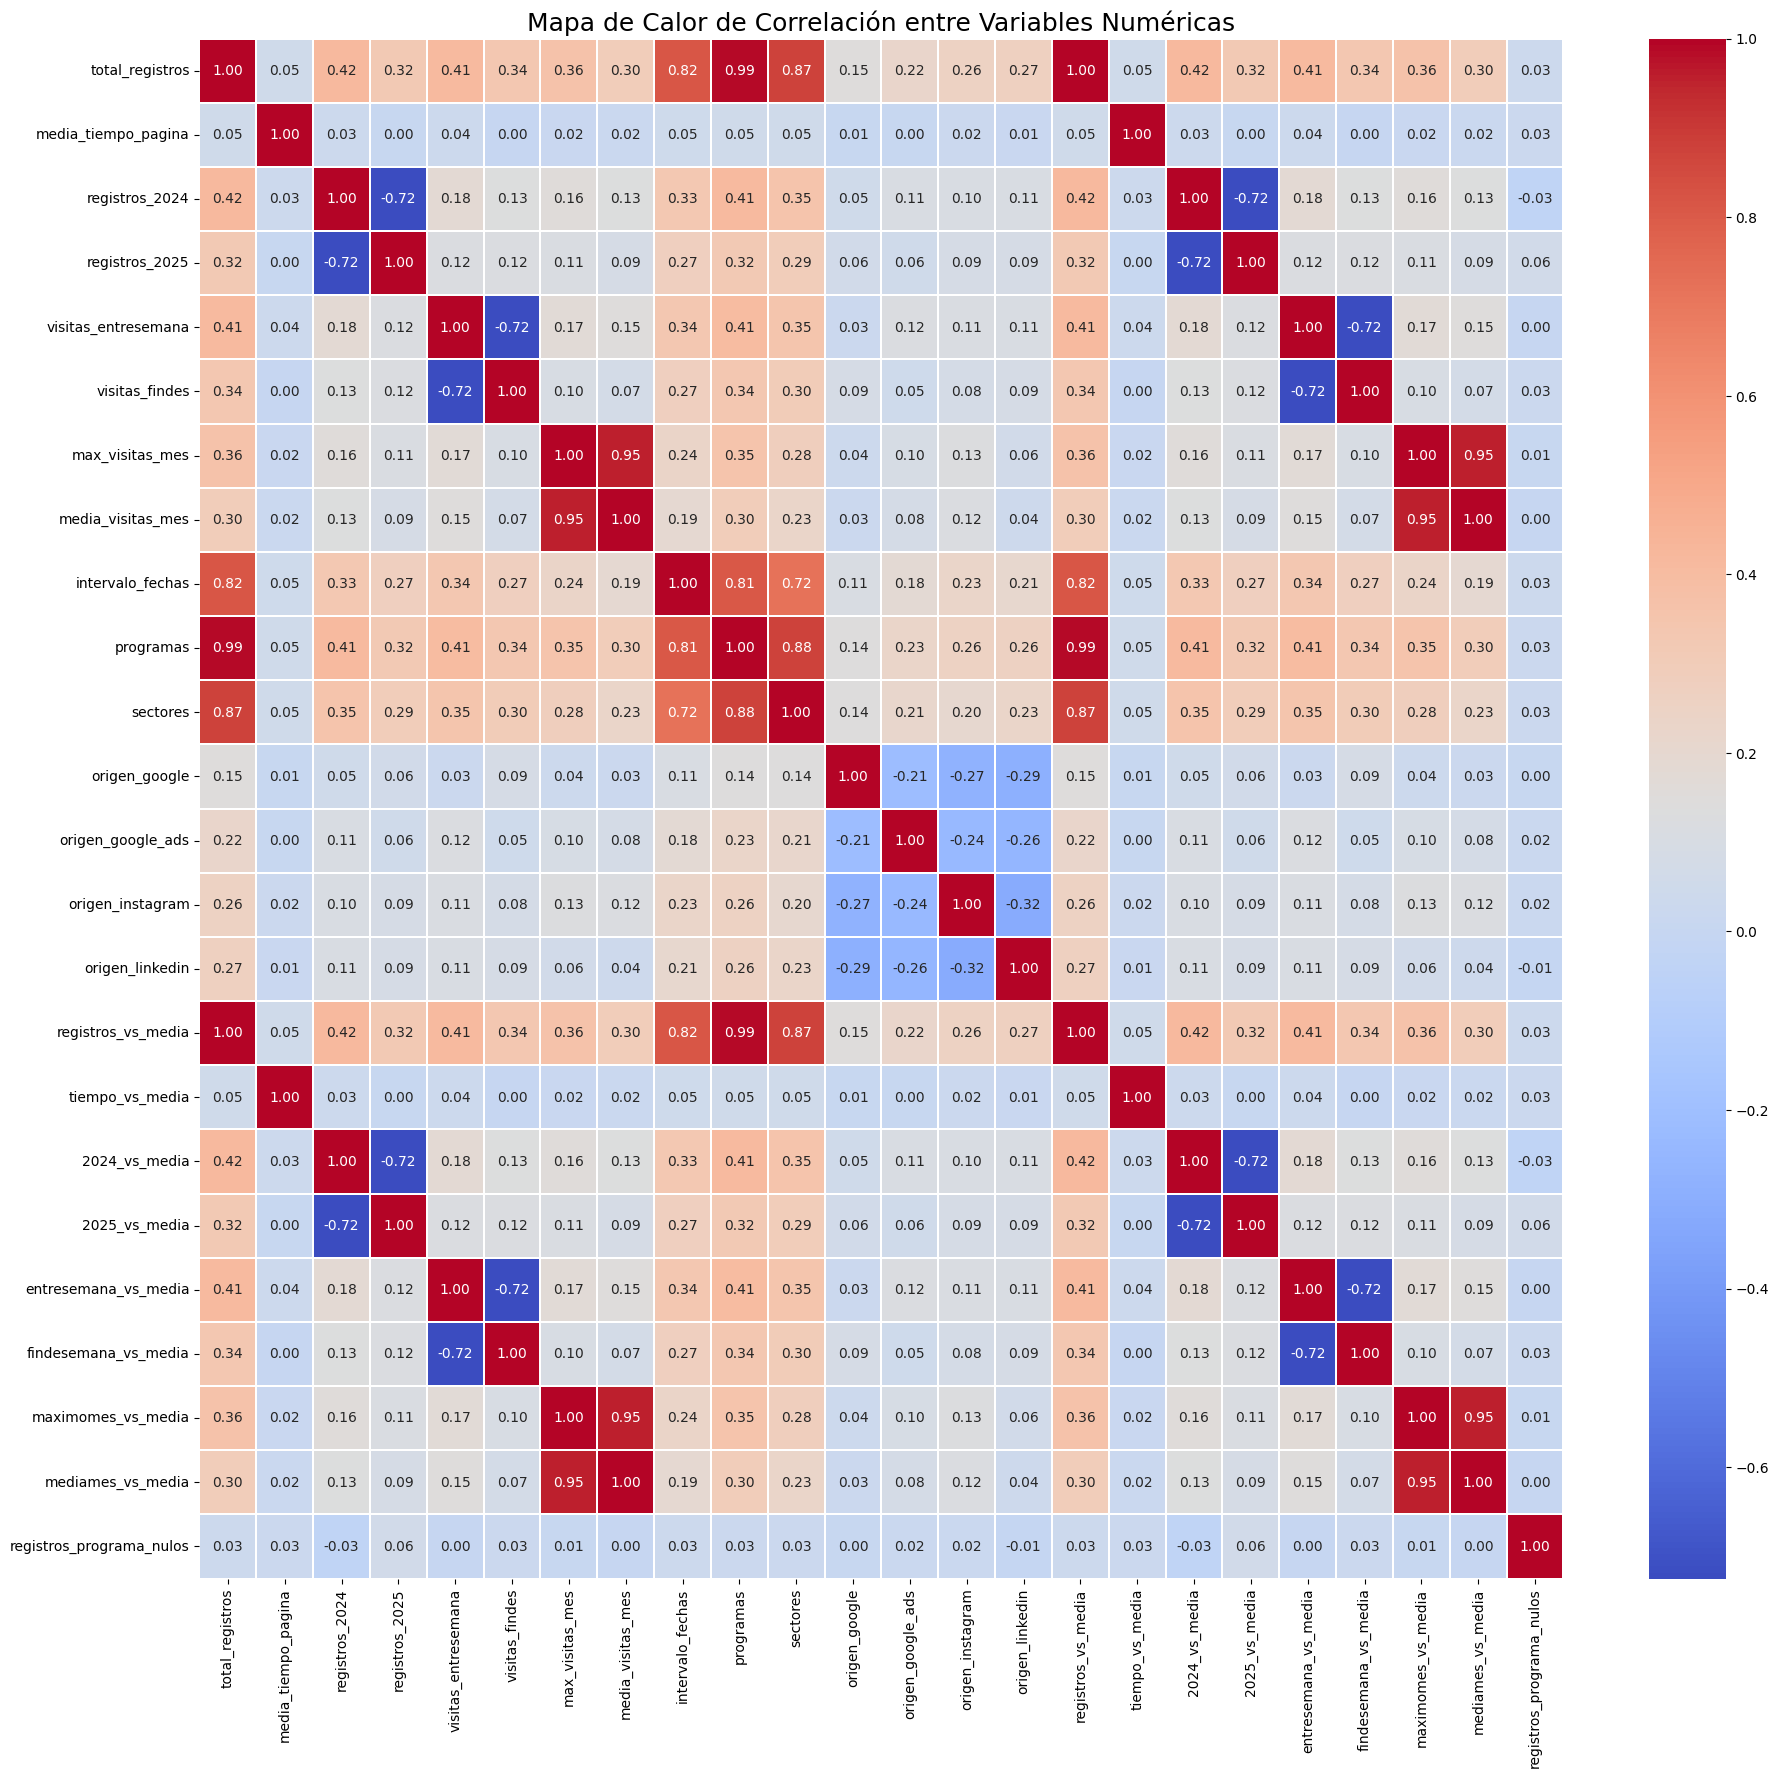

In [ ]:
# Realizamos mapa de calor de correlaciones para detectar posibles relaciones y eliminar columnas
columnas_numericas = tabla_resumen_ip.select_dtypes(include=["int64", "float64"]).columns
# Calculamos correlaciones
correlation_matrix = tabla_resumen_ip[columnas_numericas].corr()

# Paso 6: Crear el mapa de calor
plt.figure(figsize=(22, 20))  # Figura muy grande para 38 variables
sns.heatmap(correlation_matrix,
            annot=True,        # Mostrar valores
            cmap='coolwarm',   # Colores
            fmt=".2f",         # 2 decimales
            linewidths=0.3)    # Líneas entre celdas

plt.title('Mapa de Calor de Correlación entre Variables Numéricas', fontsize=18)
plt.xticks(rotation=90)  # Rotar nombres para que quepan
plt.yticks(rotation=0)
plt.show()

## 3.2 Elaboración del modelo

Inercia por número de clusters:
k=1 → Inercia=35714.63
k=2 → Inercia=17292.89
k=3 → Inercia=13194.85
k=4 → Inercia=6709.42
k=5 → Inercia=4014.89
k=6 → Inercia=3393.57
k=7 → Inercia=2147.61
k=8 → Inercia=1483.78
k=9 → Inercia=1335.8
k=10 → Inercia=921.73




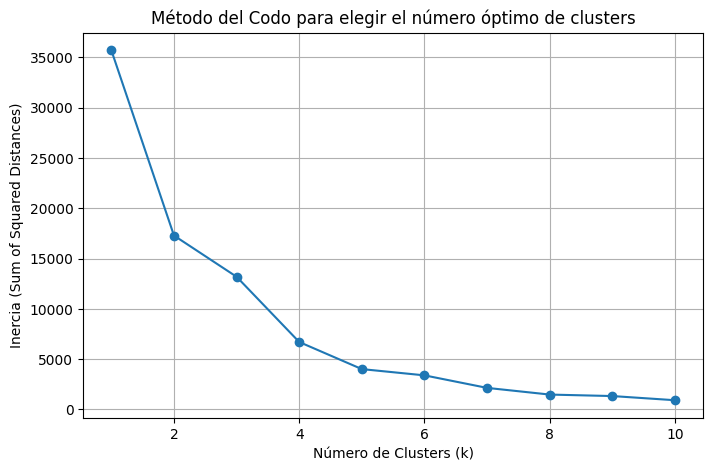

In [ ]:
metodo_codo(tabla_resumen_ip)

La gráfica nos muestra una gran bajada de la inercia para k=4 y k=5, lo que sugiere utilizar este valor en nuestro modelo.

In [ ]:
metodo_Silhouette(tabla_resumen_ip)

Silhouette promedio por número de clusters:
k=2 → Silhouette=0.6924
k=3 → Silhouette=0.6542
k=4 → Silhouette=0.698
k=5 → Silhouette=0.8659
k=6 → Silhouette=0.867
k=7 → Silhouette=0.8763
k=8 → Silhouette=0.8868
k=9 → Silhouette=0.8897
k=10 → Silhouette=0.8959
El número óptimo de cluster es: 10


Aunque Silhouette proponga k=10 como valor óptimo, vemos que el aumento del score se produce al pasar de k=4 a k=5 como pasaba también en el codo.

✅ Datos estandarizados
✅ Kmeans aplicado (k=4)
✅ Columna cluster_kmeans agregada
✅ Centroides calculados

Distribución de clusters asignados (k=4):
cluster_kmeans
0    2151
3     907
2     357
1     101
Name: count, dtype: int64


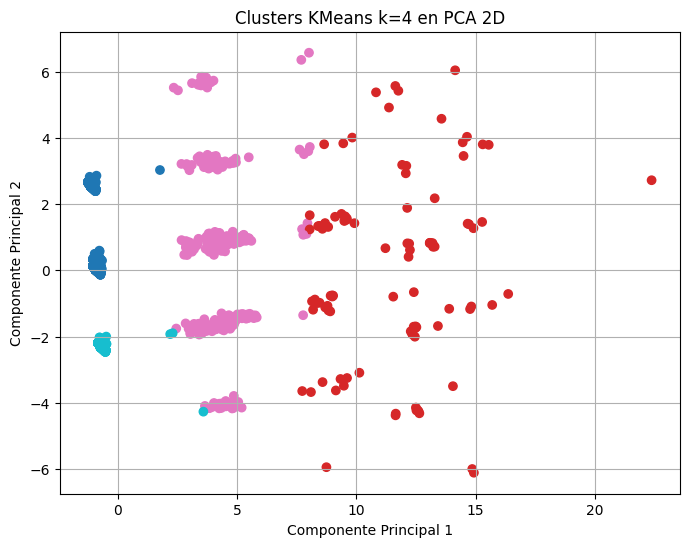

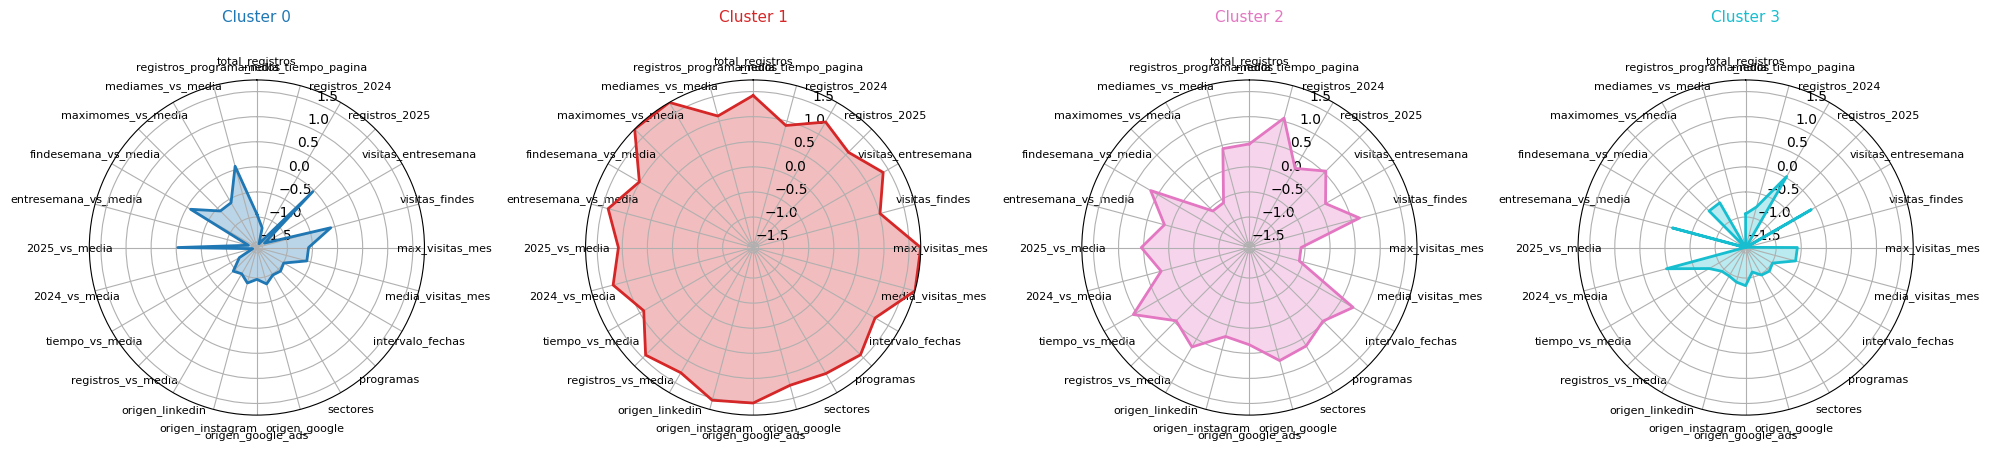

In [ ]:
data_clasificado, centroides = generar_cluster(tabla_resumen_ip,k=4)

Reducimos el número de variables para interpretar mejor el diagrama.

In [ ]:
mantener_columnas = ['cluster_kmeans', 'total_registros', 'tiempo_vs_media',
        'visitas_entresemana', 'visitas_findes', 'max_visitas_mes', 'media_visitas_mes',
       'intervalo_fechas', 'programas', 'sectores', 'mediames_vs_media',
       'registros_programa_nulos']
nuevo_centroide = centroides[mantener_columnas]

nuevo_centroide["O_Busq. directa"] = (centroides["origen_linkedin"] + centroides["origen_google"])/2
nuevo_centroide["O_Anuncios"] = (centroides["origen_google_ads"] + centroides["origen_instagram"])/2


/tmp/ipython-input-1619079043.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevo_centroide["O_Busq. directa"] = (centroides["origen_linkedin"] + centroides["origen_google"])/2
/tmp/ipython-input-1619079043.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevo_centroide["O_Anuncios"] = (centroides["origen_google_ads"] + centroides["origen_instagram"])/2


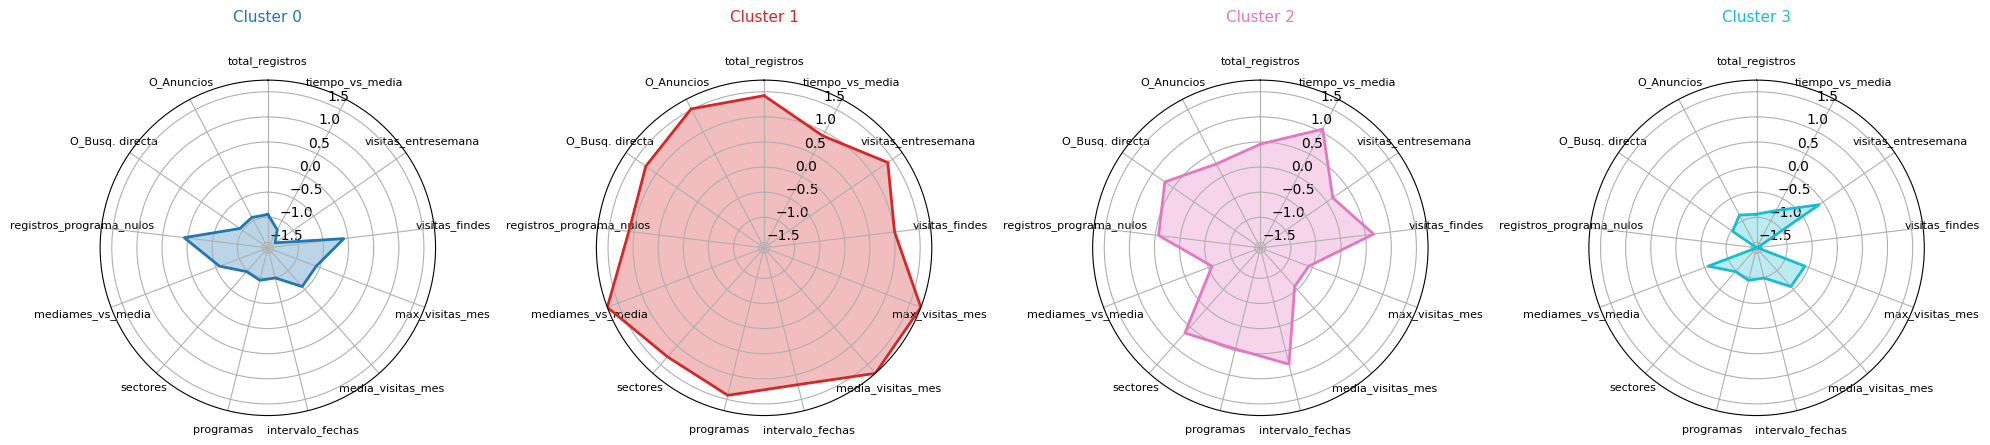

In [ ]:
representar_centroides(nuevo_centroide)

Con este gráfico podemos analizar las cualidades de cada agrupación:

- Cluster 0: Escasas visitas y muy breves. No consultan programas y suelen navegar fines de semana.

- Cluster 1: Visitan la página muchas veces durante distintos meses accediendo por distintas fuentes y consultando gran cantidad de programas y sectores

- Cluster 2: Acceden con frecuencia moderada y suelen pasar más tiempo en la página aunque a veces no consultan programas

- Cluster 3: Bajas visitas concentradas los fines de semana influenciados por anuncios. Solo revisan un programa.

Por último, comparamos con la tabla de métricas immune para ver cómo afectan a la matriculacion

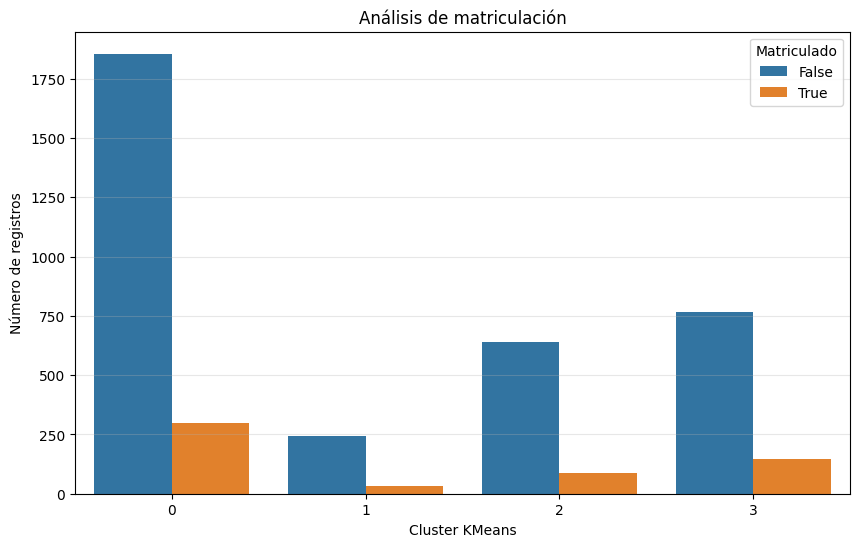

In [ ]:
analisis_matriculados = immune.merge(
    data_clasificado[["ip_usuario", "cluster_kmeans"]],
    on="ip_usuario",
    how="left"
)

plt.figure(figsize=(10, 6))

sns.countplot(
    data=analisis_matriculados,
    x="cluster_kmeans",
    hue="matriculado"
)

plt.title("Análisis de matriculación")
plt.xlabel("Cluster KMeans")
plt.ylabel("Número de registros")
plt.legend(title="Matriculado")
plt.grid(axis="y", alpha=0.3)

plt.show()

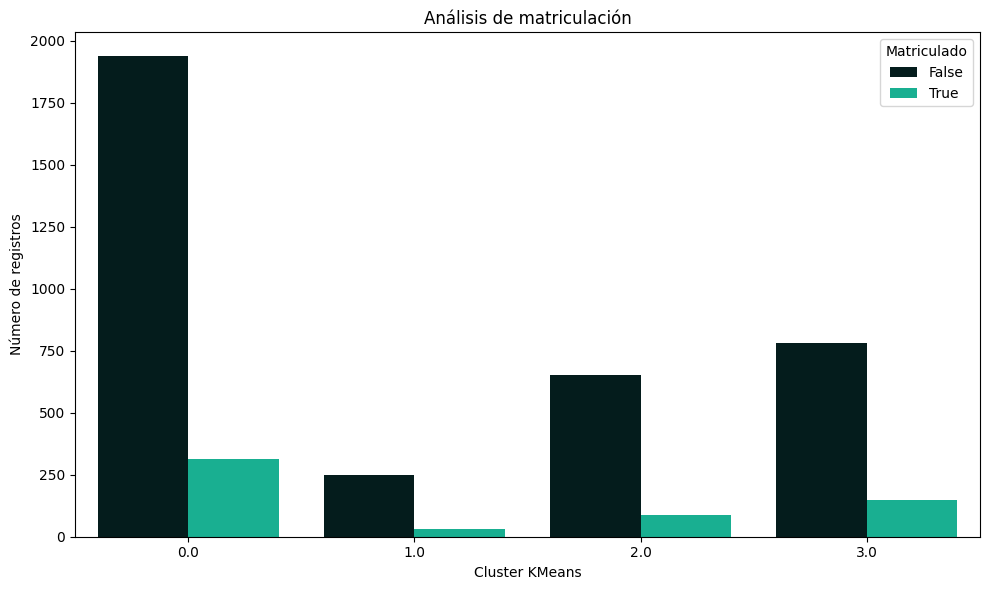

In [ ]:
## FORMATO PARA PPT
analisis_matriculados = immune.merge(
    data_clasificado[["ip_usuario", "cluster_kmeans"]],
    on="ip_usuario",
    how="left"
)

# Colores definidos
color_fondo = "#002020"   # verde oscuro
color_acento = "#00C8A0"  # turquesa

palette_matriculado = {
    0: color_fondo,   # No matriculado
    1: color_acento   # Matriculado
}

plt.figure(figsize=(10, 6))

sns.countplot(
    data=analisis_matriculados,
    x="cluster_kmeans",
    hue="matriculado",
    palette=palette_matriculado
)

plt.title("Análisis de matriculación")
plt.xlabel("Cluster KMeans")
plt.ylabel("Número de registros")
plt.legend(title="Matriculado")

plt.tight_layout()
plt.show()

# 4. Modelo de Clustering de usuarios

Para esta sección mantendremos la relación 1:1 entre id_usuario e ip_usuario e incluiremos campos que los alumnos indicaron en su formulario.

La idea es hacer una función que permita filtrar por sector, tipo de programa o el propio programa para analizar los cluster

## 4.1 Transformaciones de los datos

## 4.1.1 Transformaciones a cursos_immune.xlsx

In [ ]:
cursos = pd.read_excel("cursos_immune.xlsx")
cursos["concatenado"] = cursos["id_curso"] + " - " + cursos["nombre"]
cursos = cursos[["id_curso","concatenado","tipo_de_programa","sector"]]


## 4.1.2 Transformaciones a formularios_PBI.xlsx

In [ ]:
formulario = pd.read_excel("formularios_PBI.xlsx")

#### Incluir nuevas categorias de areas interes, areas estudios, sector laboral y quitar columnas sobrantes ###

# Analizamos valores de cada columna:
print(formulario["area_de_estudios"].unique())
print("**************************************")
print(formulario["area_de_interes_para_formarse"].unique())
print("**************************************")
print(formulario["sector_laboral"].unique())

['Informática' 'Diseño' 'Estudios obligatorios' 'Ciencias Sociales'
 'Matemáticas' 'Ingeniería' 'ADE' 'Comunicación' 'Física']
**************************************
['Informática' 'Diseño' 'Comunicación' 'Ciencias Sociales' 'Matemáticas'
 'Ingeniería' 'Física' 'ADE' 'Tecnologías de la información']
**************************************
['Tecnologías de la información' 'Diseño gráfico' 'Comunicación'
 'Investigación' 'Educación' 'Construcción' 'Finanzas' 'Diseño'
 'Ingeniería' 'Estudiantes' 'Tecnología' 'Medios' 'Ciencias' 'Negocios'
 'Arte' 'Social']


Como los valores de ambas columnas son muy similares, estableceremos una única lista de categorías para area_de_estudios y area_de_interes_para_formarse

In [ ]:
categorias = {
    "Informática": "Tecnología",
    "Tecnologías de la información": "Tecnología",
    "Ingeniería": "Tecnología",
    "Física": "Ciencia",
    "Matemáticas": "Ciencia",
    "Ciencias Sociales": "Humanidades y Sociales",
    "Comunicación": "Humanidades y Sociales",
    "Diseño": "Arte y Diseño",
    "ADE": "Economía y Empresa",
    "Estudios obligatorios": "Educ. Básica"
}
sectores = {
    "Tecnologías de la información": "Tecnología",
    "Tecnología": "Tecnología",
    "Ingeniería": "Tecnología",
    "Diseño gráfico": "Tecnología",

    "Investigación": "Ciencia",
    "Ciencias": "Ciencia",
    "Educación": "Humanidades",

    "Diseño": "Arte",
    "Arte": "Arte",
    "Construcción": "Arte",

    "Comunicación": "Humanidades",
    "Medios": "Humanidades",

    "Social": "Humanidades",

    "Estudiantes": "Sin experiencia",

    "Finanzas": "Negocio",
    "Negocios": "Negocio"
}

In [ ]:
# Creación de la nueva columna
formulario["E"] = formulario["area_de_estudios"].map(categorias)
formulario["I"] = formulario["area_de_interes_para_formarse"].map(categorias)
formulario["S"] = formulario["sector_laboral"].map(sectores)
formulario = formulario.rename(columns={
    "titulacion_academica": "T",
    "motivo_de_la_formacion": "M"
})
formulario["tipo_alumno"] = (formulario["pais"] != "España").astype(int)

In [ ]:
# Eliminamos las columnas que no usaremos en la clasificación o que hemos reducido en menos categorias
formulario = formulario.drop(columns=["ciudad","pais","genero","area_de_interes_para_formarse","area_de_estudios","sector_laboral"])
# Aplicamos OneHot a las categorias:
one_hot = ["E","I","S","T","M"]
formulario = pd.get_dummies(formulario, columns=one_hot)

In [ ]:
formulario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id_usuario                700 non-null    object
 1   edad                      700 non-null    int64 
 2   experiencia_laboral       700 non-null    int64 
 3   tipo_alumno               700 non-null    int64 
 4   E_Arte y Diseño           700 non-null    bool  
 5   E_Ciencia                 700 non-null    bool  
 6   E_Economía y Empresa      700 non-null    bool  
 7   E_Educ. Básica            700 non-null    bool  
 8   E_Humanidades y Sociales  700 non-null    bool  
 9   E_Tecnología              700 non-null    bool  
 10  I_Arte y Diseño           700 non-null    bool  
 11  I_Ciencia                 700 non-null    bool  
 12  I_Economía y Empresa      700 non-null    bool  
 13  I_Humanidades y Sociales  700 non-null    bool  
 14  I_Tecnología              

## 4.1.3 Transformaciones a Immune_metricas_PBI

Tenemos que completar los registros de ip nulos que ya hayan tenido id_usuario como en el apartado anterior y generar la tabla de métricas globales pero esta vez agrupando por id_usuario

In [ ]:
# Importamos dataset
immune = pd.read_excel("Immune_metricas_PBI.xlsx")

# Paso 1: filtrar filas donde el usuario no es nulo
auxiliar = immune[["id_usuario", "ip_usuario"]].dropna(subset=["id_usuario"])
# Paso 2: quedarnos con 1 fila por usuario
relacion_ip_usuario = auxiliar.drop_duplicates(subset="id_usuario")[["id_usuario", "ip_usuario"]]
print(relacion_ip_usuario.describe())
# Paso 3: Eliminamos la columna id_usuario de immune para poder completarla con la tabla relacion_ip_usuario
immune.drop(columns=["id_usuario"], inplace=True)
immune = immune.merge(
    relacion_ip_usuario[["id_usuario", "ip_usuario"]],
    on="ip_usuario",
    how="left"
)

       id_usuario       ip_usuario
count         700              700
unique        700              700
top         U0317  132.240.218.201
freq            1                1


In [ ]:
# Paso 4: Nos quedamos solo con los registros que tienen id_usuario informado
immune = immune[~immune["id_usuario"].isnull()]
# Paso 5: Seleccionamos las columnas que necesitamos
mantener_columnas = ["id_usuario","origen_plataforma","tiempo_en_pagina","fecha_hora","programa_oferta_click","año","mes","dia_semana"]
immune = immune[mantener_columnas]
immune = immune.rename(columns={"programa_oferta_click":"id_curso"})
# Paso 6: Agragamos la columna sector de la tabla cursos
immune = immune.merge(
    cursos[["id_curso", "sector"]],
    on="id_curso",
    how="left"
)
print(immune.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_usuario         906 non-null    object        
 1   origen_plataforma  906 non-null    object        
 2   tiempo_en_pagina   906 non-null    int64         
 3   fecha_hora         906 non-null    datetime64[ns]
 4   id_curso           740 non-null    object        
 5   año                906 non-null    int64         
 6   mes                906 non-null    int64         
 7   dia_semana         906 non-null    int64         
 8   sector             740 non-null    object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 63.8+ KB
None


In [ ]:
# Paso 7: A partir de la tabla immune podemos generar la tabla de visitas
visitas_usuario = immune.groupby("id_usuario").agg(
    registros=("id_usuario", lambda m: m.count()),
    media_registros_anual=("año", lambda a: a.value_counts().mean()),
    media_visitas_mes=("mes", lambda m: m.value_counts().mean()),
    media_tiempo_pagina=("tiempo_en_pagina", lambda x: x.mean() / 60),
    visitas_entresemana=("dia_semana", lambda x: x.isin([0,1,2,3]).sum()),
    visitas_findes=("dia_semana", lambda x: x.isin([4,5,6]).sum()),
    programas_vistos=("id_curso", lambda c: c.nunique()),
    sectores_vistos=("sector", lambda s: s.nunique()),
).reset_index()

In [ ]:
visitas_usuario.head(10)

id_usuario  registros  media_registros_anual  media_visitas_mes  \
0      U0001          1                    1.0                1.0   
1      U0002          1                    1.0                1.0   
2      U0003          1                    1.0                1.0   
3      U0004          2                    2.0                1.0   
4      U0005          1                    1.0                1.0   
5      U0006          1                    1.0                1.0   
6      U0007          1                    1.0                1.0   
7      U0008          1                    1.0                1.0   
8      U0009          3                    3.0                1.0   
9      U0010          1                    1.0                1.0   

   media_tiempo_pagina  visitas_entresemana  visitas_findes  programas_vistos  \
0             4.183333                    0               1                 1   
1             1.000000                    0               1                 1   
2             4.316667                    1               0                 1   
3             1.550000                    2               0                 2   
4             1.000000                    0               1                 1   
5             1.450000                    0               1                 1   
6             1.000000                    0               1                 1   
7             3.716667                    1               0                 1   
8             2.183333                    1               2                 2   
9             0.850000                    1               0                 1   

   sectores_vistos  
0                1  
1                1  
2                1  
3                1  
4                1  
5                1  
6                1  
7                1  
8                2  
9                1

In [ ]:
# Paso 8: Unificamos las tablas formulario y visitas_usuario
data_usuarios = formulario.merge(
    visitas_usuario,
    on="id_usuario",
    how="left"
)
data_usuarios.head(70)

id_usuario  edad  experiencia_laboral  tipo_alumno  E_Arte y Diseño  \
0       U0001    40                    3            0            False   
1       U0002    29                    5            0             True   
2       U0003    23                    1            1            False   
3       U0004    24                    6            1            False   
4       U0005    35                   10            1            False   
..        ...   ...                  ...          ...              ...   
65      U0066    37                    6            1            False   
66      U0067    48                   20            1             True   
67      U0068    26                    7            1            False   
68      U0069    32                   11            1            False   
69      U0070    28                    5            1            False   

    E_Ciencia  E_Economía y Empresa  E_Educ. Básica  E_Humanidades y Sociales  \
0       False                 False           False                     False   
1       False                 False           False                     False   
2       False                 False            True                     False   
3       False                 False           False                      True   
4        True                 False           False                     False   
..        ...                   ...             ...                       ...   
65      False                 False           False                      True   
66      False                 False           False                     False   
67      False                 False           False                     False   
68      False                 False           False                     False   
69      False                 False           False                      True   

    E_Tecnología  ...  M_Cambio de trabajo  M_Escalar en el trabajo  \
0           True  ...                False                     True   
1          False  ...                 True                    False   
2          False  ...                False                    False   
3          False  ...                False                    False   
4          False  ...                False                     True   
..           ...  ...                  ...                      ...   
65         False  ...                 True                    False   
66         False  ...                False                    False   
67          True  ...                False                     True   
68          True  ...                False                    False   
69         False  ...                 True                    False   

    registros  media_registros_anual  media_visitas_mes  media_tiempo_pagina  \
0           1                    1.0                1.0             4.183333   
1           1                    1.0                1.0             1.000000   
2           1                    1.0                1.0             4.316667   
3           2                    2.0                1.0             1.550000   
4           1                    1.0                1.0             1.000000   
..        ...                    ...                ...                  ...   
65          3                    1.5                1.0             3.922222   
66          1                    1.0                1.0             1.783333   
67          1                    1.0                1.0             8.400000   
68          1                    1.0                1.0            14.583333   
69          2                    2.0                1.0             2.391667   

    visitas_entresemana  visitas_findes  programas_vistos  sectores_vistos  
0                     0               1                 1                1  
1                     0               1                 1                1  
2                     1               0                 1                1  
3                  

In [ ]:
# Convertimos a variables numéricas los booleanos
data_usuarios = data_usuarios.astype({col: int for col in data_usuarios.select_dtypes(include="bool").columns})

## 4.2 Analizamos datos

In [ ]:
data_usuarios.describe()

edad  experiencia_laboral  tipo_alumno  E_Arte y Diseño  \
count  700.000000           700.000000   700.000000       700.000000   
mean    29.778571             6.310000     0.832857         0.107143   
std      8.146080             6.108899     0.373370         0.309516   
min     18.000000             0.000000     0.000000         0.000000   
25%     23.000000             1.000000     1.000000         0.000000   
50%     29.000000             5.000000     1.000000         0.000000   
75%     36.000000            10.000000     1.000000         0.000000   
max     50.000000            29.000000     1.000000         1.000000   

        E_Ciencia  E_Economía y Empresa  E_Educ. Básica  \
count  700.000000            700.000000      700.000000   
mean     0.200000              0.052857        0.221429   
std      0.400286              0.223908        0.415505   
min      0.000000              0.000000        0.000000   
25%      0.000000              0.000000        0.000000   
50%      0.000000              0.000000        0.000000   
75%      0.000000              0.000000        0.000000   
max      1.000000              1.000000        1.000000   

       E_Humanidades y Sociales  E_Tecnología  I_Arte y Diseño  ...  \
count                700.000000    700.000000       700.000000  ...   
mean                   0.205714      0.212857         0.125714  ...   
std                    0.404512      0.409620         0.331764  ...   
min                    0.000000      0.000000         0.000000  ...   
25%                    0.000000      0.000000         0.000000  ...   
50%                    0.000000      0.000000         0.000000  ...   
75%                    0.000000      0.000000         0.000000  ...   
max                    1.000000      1.000000         1.000000  ...   

       M_Cambio de trabajo  M_Escalar en el trabajo   registros  \
count           700.000000               700.000000  700.000000   
mean              0.262857                 0.238571    1.294286   
std               0.440500                 0.426515    0.602067   
min               0.000000                 0.000000    1.000000   
25%               0.000000                 0.000000    1.000000   
50%               0.000000                 0.000000    1.000000   
75%               1.000000                 0.000000    1.000000   
max               1.000000                 1.000000    6.000000   

       media_registros_anual  media_visitas_mes  media_tiempo_pagina  \
count             700.000000         700.000000           700.000000   
mean                1.126429           1.021476             4.169010   
std                 0.349864           0.139375             3.729621   
min                 1.000000           1.000000             0.166667   
25%                 1.000000           1.000000             1.150000   
50%                 1.000000           1.000000             2.911111   
75%                 1.000000           1.000000             6.244444   
max                 3.000000           2.000000            15.000000   

       visitas_entresemana  visitas_findes  programas_vistos  sectores_vistos  
count           700.000000      700.000000        700.000000       700.000000  
mean              0.754286        0.540000          1.050000         0.990000  
std               0.648247        0.614419          0.690473         0.594358  
min               0.000000        0.000000          0.000000         0.000000  
25%               0.000000        0.000000          1.000000         1.000000  
50%               1.000000        0.000000          1.000000         1.000000  
75%               1.000000        1.000000          1.000000         1.000000  
max               3.000000        3.000000          4.000000         3.000000  

[8 rows x 37 columns]

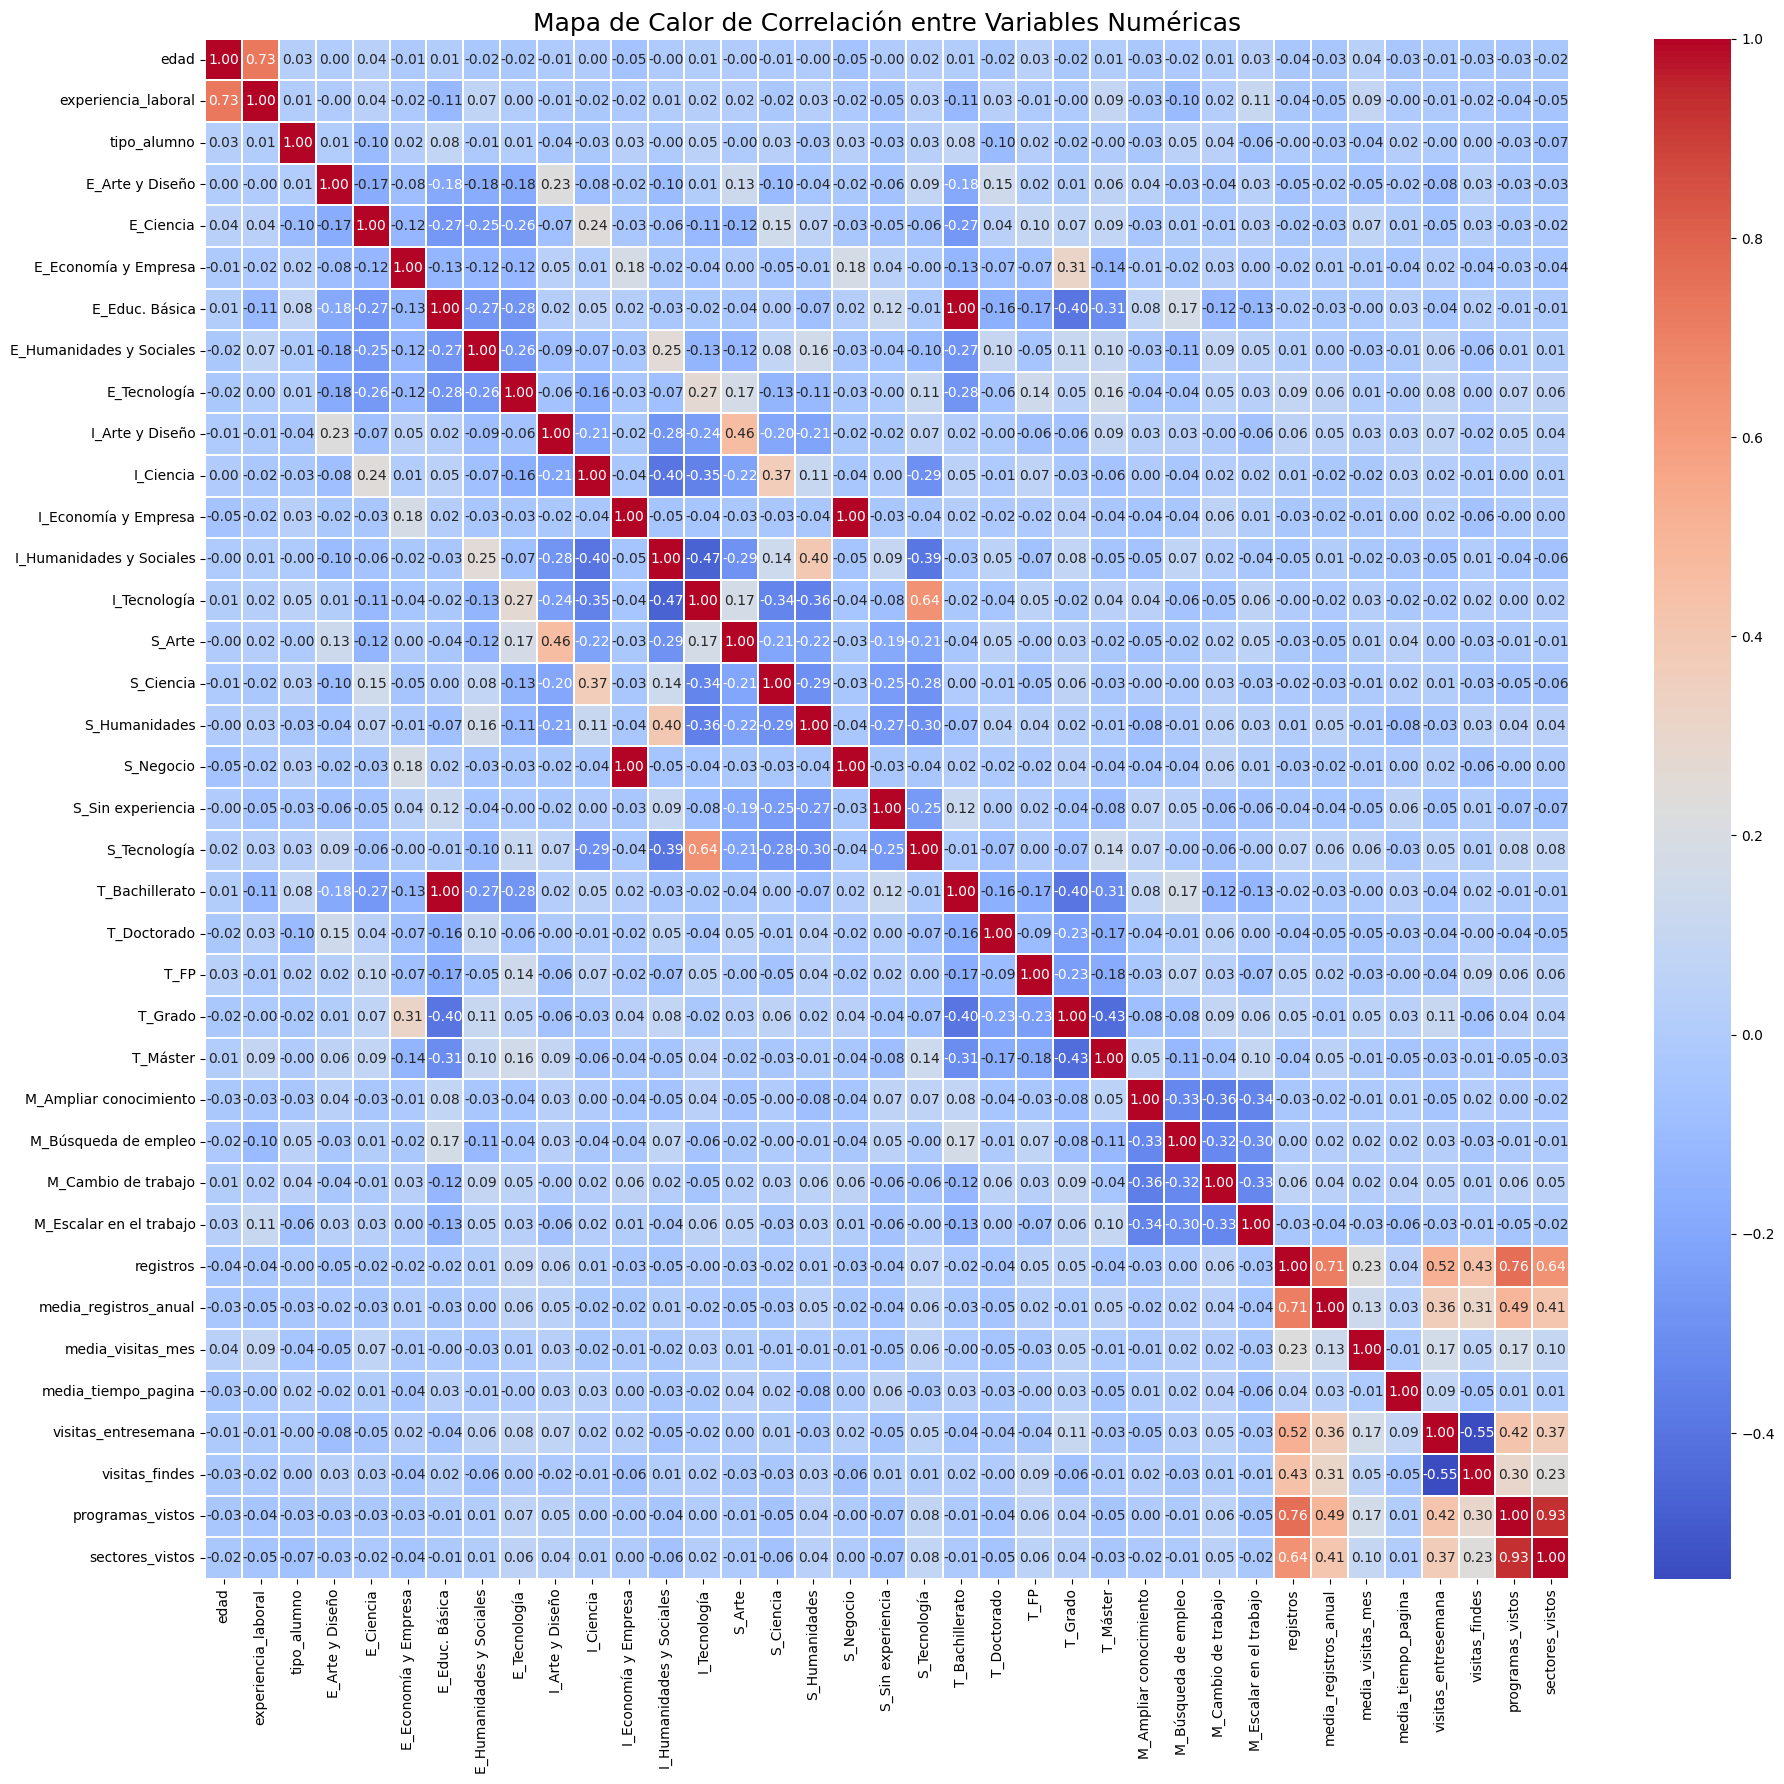

In [ ]:
# Realizamos mapa de calor de correlaciones para detectar posibles relaciones y eliminar columnas
columnas_numericas = data_usuarios.select_dtypes(include=["int64", "float64"]).columns
# Calculamos correlaciones
correlation_matrix = data_usuarios[columnas_numericas].corr()

# Paso 6: Crear el mapa de calor
plt.figure(figsize=(22, 20))  # Figura muy grande para 38 variables
sns.heatmap(correlation_matrix,
            annot=True,        # Mostrar valores
            cmap='coolwarm',   # Colores
            fmt=".2f",         # 2 decimales
            linewidths=0.3)    # Líneas entre celdas

plt.title('Mapa de Calor de Correlación entre Variables Numéricas', fontsize=18)
plt.xticks(rotation=90)  # Rotar nombres para que quepan
plt.yticks(rotation=0)
plt.show()

Se observa que hay una gran dependiencia entre las variables T_Bachillerato y E_Educ. Básica (tiene sentido al ser estudiantes) y S_Negocio con I_Economía y Empresa por lo que podemos eliminar dos de estas variables

In [ ]:
data_usuarios.drop(columns=["E_Educ. Básica","I_Economía y Empresa"],inplace=True)

Inercia por número de clusters:
k=1 → Inercia=4426.05
k=2 → Inercia=2621.39
k=3 → Inercia=1229.78
k=4 → Inercia=904.66
k=5 → Inercia=681.32
k=6 → Inercia=554.06
k=7 → Inercia=515.9
k=8 → Inercia=407.86
k=9 → Inercia=364.31
k=10 → Inercia=347.59




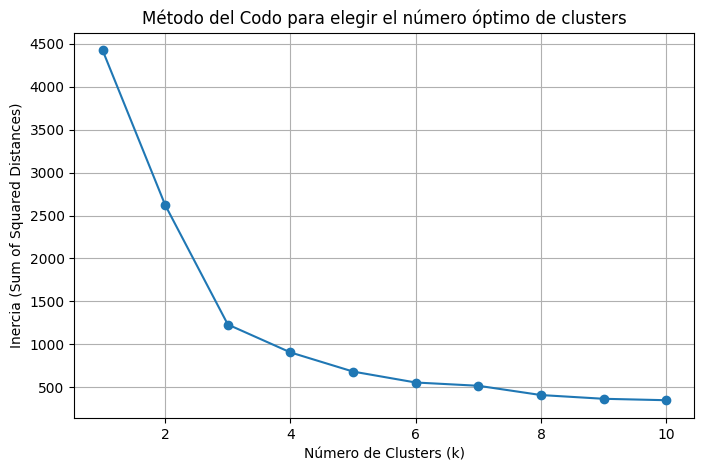

In [ ]:
metodo_codo(data_usuarios)

In [ ]:
metodo_Silhouette(data_usuarios)

Silhouette promedio por número de clusters:
k=2 → Silhouette=0.4952
k=3 → Silhouette=0.5709
k=4 → Silhouette=0.5846
k=5 → Silhouette=0.5974
k=6 → Silhouette=0.5527
k=7 → Silhouette=0.55
k=8 → Silhouette=0.4938
k=9 → Silhouette=0.4785
k=10 → Silhouette=0.4502
El número óptimo de cluster es: 5


La gráfica del método del codo indica una gran baja de inercia en k=3, mientras que Silhouette sugiere 5 cluster distintos.

Probaremos con ambos valores

## 4.3 Representación de Cluster (k=3)

✅ Datos estandarizados
✅ Kmeans aplicado (k=3)
✅ Columna cluster_kmeans agregada
✅ Centroides calculados

Distribución de clusters asignados (k=3):
cluster_kmeans
1    335
2    237
0    128
Name: count, dtype: int64


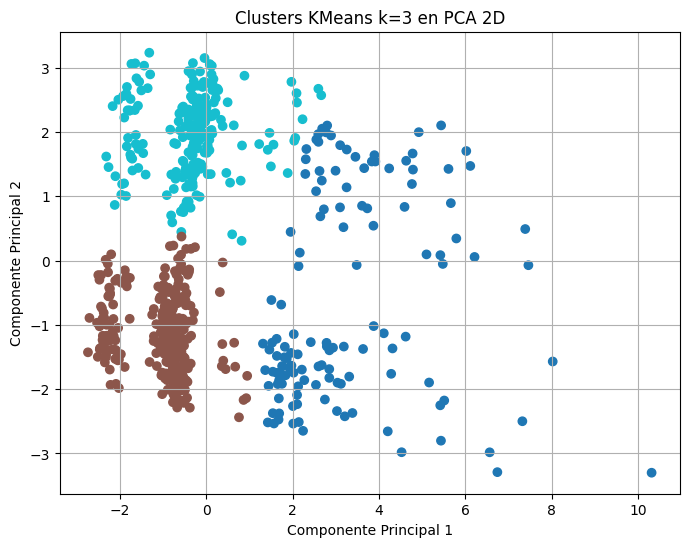

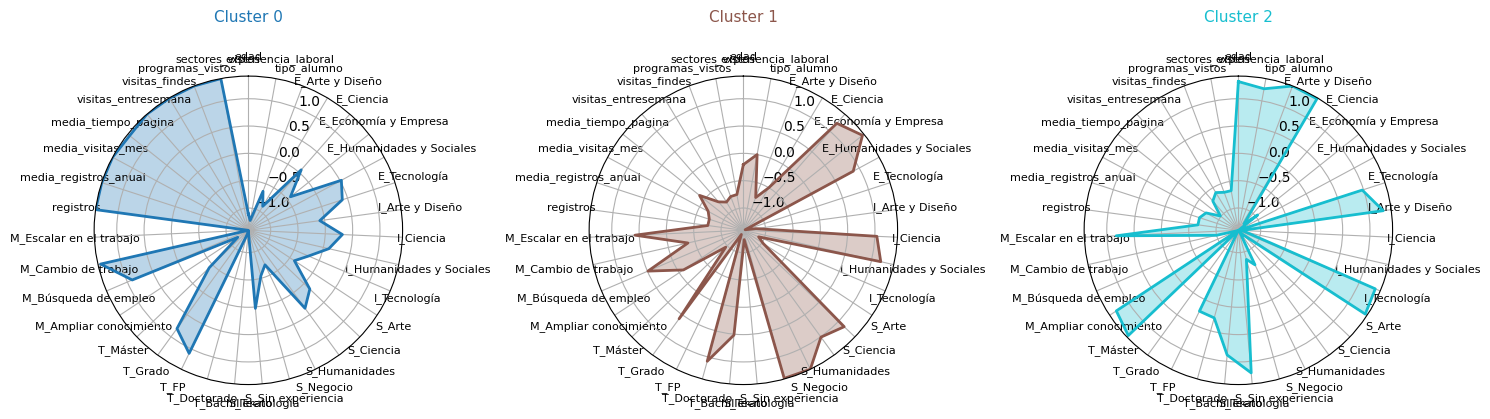

In [ ]:
usuarios_clasificado, centroides_usuario = generar_cluster(data_usuarios,3)

Intentaremos reducir el número de variables para facilitar el análisis:

In [ ]:
centroides_usuario.columns

Index(['cluster_kmeans', 'edad', 'experiencia_laboral', 'tipo_alumno',
       'E_Arte y Diseño', 'E_Ciencia', 'E_Economía y Empresa',
       'E_Humanidades y Sociales', 'E_Tecnología', 'I_Arte y Diseño',
       'I_Ciencia', 'I_Humanidades y Sociales', 'I_Tecnología', 'S_Arte',
       'S_Ciencia', 'S_Humanidades', 'S_Negocio', 'S_Sin experiencia',
       'S_Tecnología', 'T_Bachillerato', 'T_Doctorado', 'T_FP', 'T_Grado',
       'T_Máster', 'M_Ampliar conocimiento', 'M_Búsqueda de empleo',
       'M_Cambio de trabajo', 'M_Escalar en el trabajo', 'registros',
       'media_registros_anual', 'media_visitas_mes', 'media_tiempo_pagina',
       'visitas_entresemana', 'visitas_findes', 'programas_vistos',
       'sectores_vistos'],
      dtype='object')

In [ ]:
col_a_mantener = ['cluster_kmeans', 'edad', 'experiencia_laboral','registros','media_visitas_mes', 'media_tiempo_pagina',
       'visitas_entresemana', 'visitas_findes', 'programas_vistos', 'sectores_vistos']
centroide_reducido = centroides_usuario[col_a_mantener]

centroide_reducido["M_conocimiento"] = (centroides_usuario["M_Escalar en el trabajo"] + centroides_usuario["M_Ampliar conocimiento"])/2
centroide_reducido["M_empleo"] = (centroides_usuario["M_Búsqueda de empleo"] + centroides_usuario["M_Cambio de trabajo"])/2
centroide_reducido["E_Match"] = (centroides_usuario["E_Ciencia"] + centroides_usuario["E_Tecnología"])/2
centroide_reducido["E_NoMatch"] = (centroides_usuario["E_Arte y Diseño"] + centroides_usuario["E_Economía y Empresa"])/2
centroide_reducido["I_Match"] = (centroides_usuario["I_Ciencia"] + centroides_usuario["I_Tecnología"])/2
centroide_reducido["I_NoMatch"] = (centroides_usuario["I_Arte y Diseño"] + centroides_usuario["I_Humanidades y Sociales"])/2
centroide_reducido["S_Match"] = (centroides_usuario["S_Ciencia"] + centroides_usuario["S_Tecnología"] + centroides_usuario["S_Negocio"])/3
centroide_reducido["S_NoMatch"] = (centroides_usuario["S_Arte"] + centroides_usuario["S_Humanidades"] + centroides_usuario["S_Sin experiencia"])/3
centroide_reducido["T_Avanzada"] = (centroides_usuario["T_Doctorado"] + centroides_usuario["T_Máster"])/2
centroide_reducido["T_Media"] = (centroides_usuario["T_FP"] + centroides_usuario["T_Grado"])/2
centroide_reducido["T_Basica"] = centroides_usuario["T_Bachillerato"]

/tmp/ipython-input-2196216249.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centroide_reducido["M_conocimiento"] = (centroides_usuario["M_Escalar en el trabajo"] + centroides_usuario["M_Ampliar conocimiento"])/2
/tmp/ipython-input-2196216249.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centroide_reducido["M_empleo"] = (centroides_usuario["M_Búsqueda de empleo"] + centroides_usuario["M_Cambio de trabajo"])/2
/tmp/ipython-input-2196216249.py:7: SettingWithCopyWarning: 
A value is trying to be set

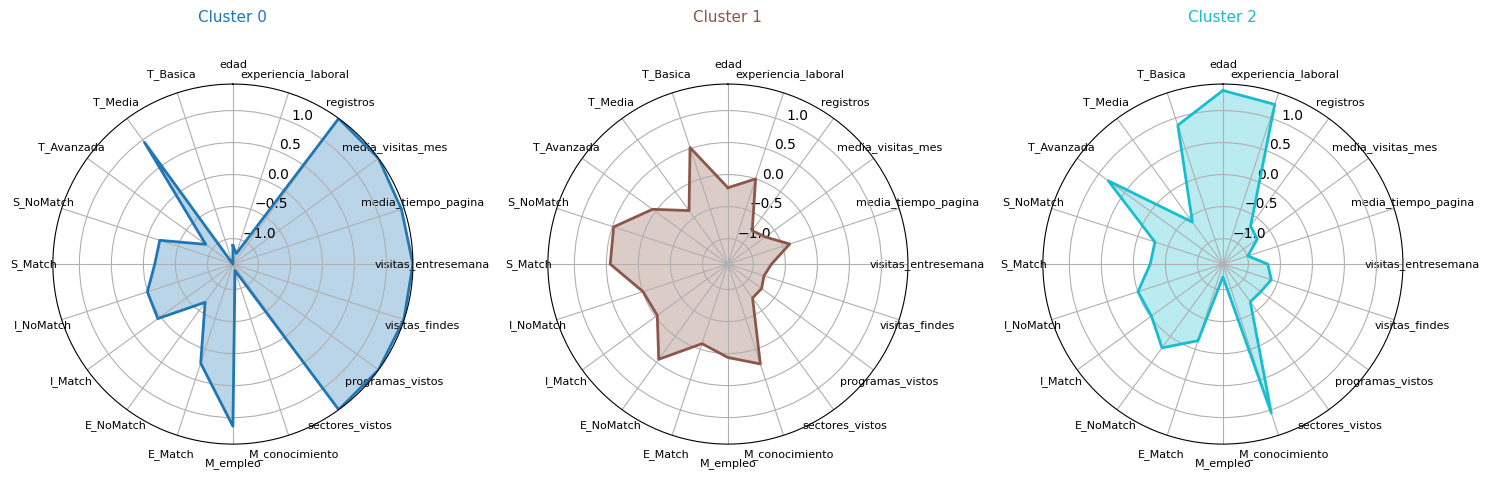

In [ ]:
representar_centroides(centroide_reducido)

De la gráfica podemos obtener las características de cada cluster:

- Cluster 0: Jóvenes sin experiencia laboral que han terminado su grado o FP y buscan un primer empleo. Pasan mucho tiempo en la página consultando varios programas y sectores.

- Cluster 1: Personas con titulación básica, con experiencia y estudios diferentes a los ofertados en Immune que consultan pocos programas en busca de conocimiento o ascenso en su empresa.

- Cluster 2: Adultos con titulaciones de Máster o Doctorados y amplia experiencia laboral que consultan los programas para adquirir conocimiento.

Veamos cómo afectan estos cluster a la matriculación:

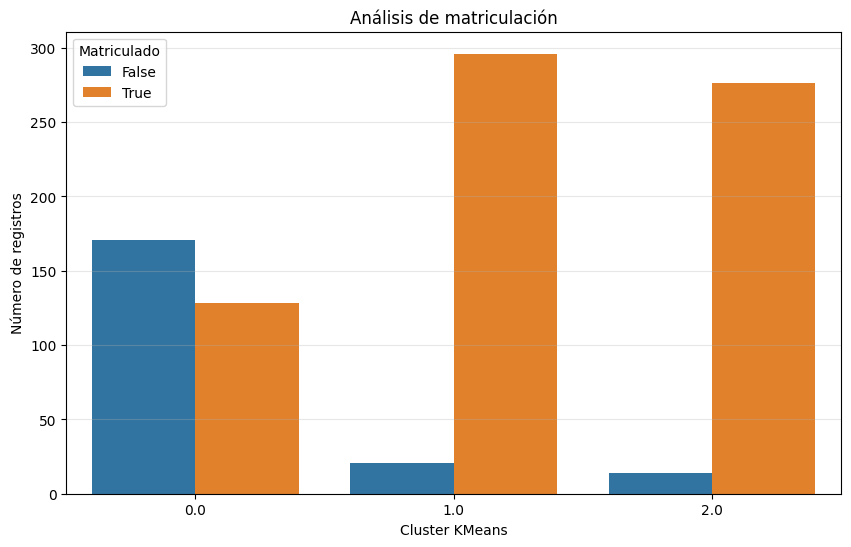

In [ ]:
immune = pd.read_excel("Immune_metricas_PBI.xlsx")
analisis_matriculados = immune.merge(
    usuarios_clasificado[["id_usuario", "cluster_kmeans"]],
    on="id_usuario",
    how="left"
)

plt.figure(figsize=(10, 6))

sns.countplot(
    data=analisis_matriculados,
    x="cluster_kmeans",
    hue="matriculado"
)

plt.title("Análisis de matriculación")
plt.xlabel("Cluster KMeans")
plt.ylabel("Número de registros")
plt.legend(title="Matriculado")
plt.grid(axis="y", alpha=0.3)

plt.show()

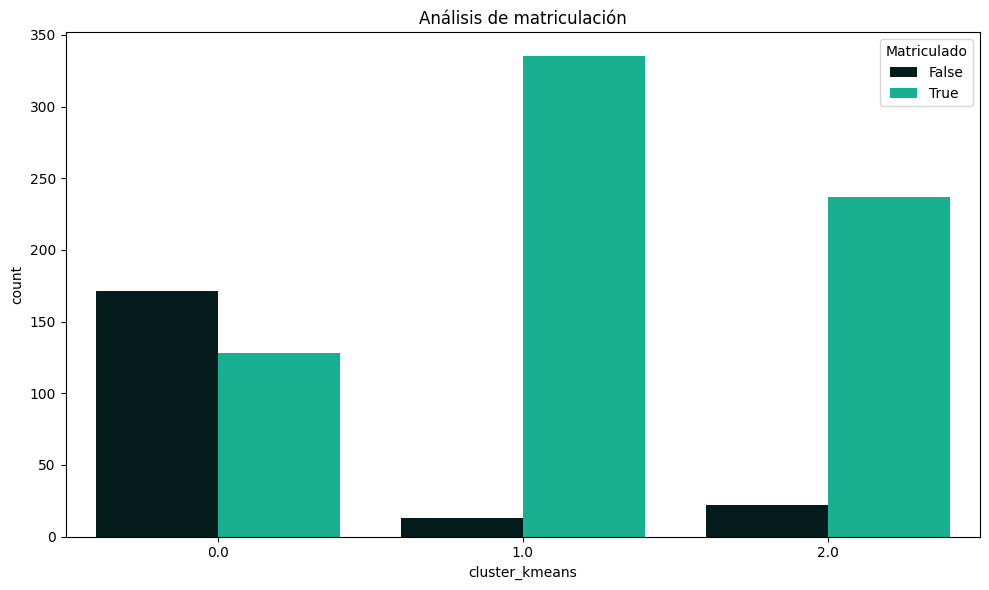

In [ ]:
## FORMATO PARA PPT
immune = pd.read_excel("Immune_metricas_PBI.xlsx")

analisis_matriculados = immune.merge(
    usuarios_clasificado[["id_usuario", "cluster_kmeans"]],
    on="id_usuario",
    how="left"
)

# Colores definidos
color_fondo = "#002020"   # verde petróleo oscuro
color_acento = "#00C8A0"  # turquesa

palette_matriculado = {
    0: color_fondo,   # No matriculado
    1: color_acento   # Matriculado
}

plt.figure(figsize=(10, 6))

sns.countplot(
    data=analisis_matriculados,
    x="cluster_kmeans",
    hue="matriculado",
    palette=palette_matriculado
)

plt.title("Análisis de matriculación")
plt.legend(title="Matriculado")

plt.tight_layout()
plt.show()

## 4.4 Representación de Cluster (k=5)

✅ Datos estandarizados
✅ Kmeans aplicado (k=5)
✅ Columna cluster_kmeans agregada
✅ Centroides calculados

Distribución de clusters asignados (k=5):
cluster_kmeans
1    329
2    224
0     68
4     55
3     24
Name: count, dtype: int64


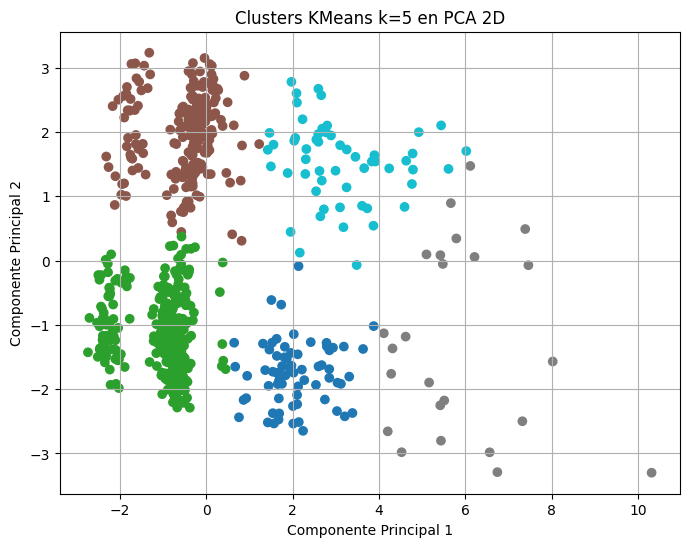

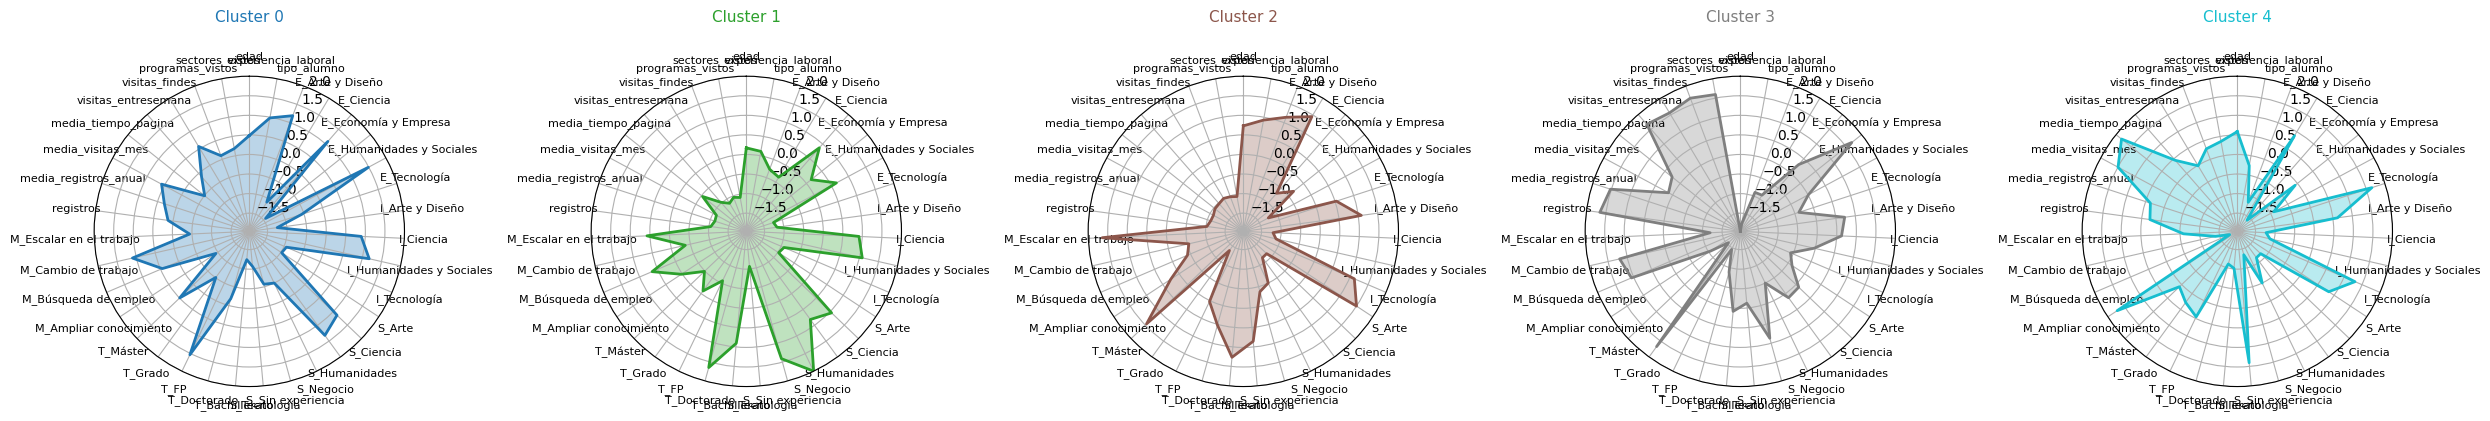

In [ ]:
usuarios_clasificado, centroides_usuario = generar_cluster(data_usuarios,5)

De nuevo, reducimos el número de variables a representar en el centroide:

In [ ]:
col_a_mantener = ['cluster_kmeans', 'edad', 'experiencia_laboral','registros','media_visitas_mes', 'media_tiempo_pagina',
       'visitas_entresemana', 'visitas_findes', 'programas_vistos', 'sectores_vistos']
centroide_reducido = centroides_usuario[col_a_mantener]

centroide_reducido["M_conocimiento"] = (centroides_usuario["M_Escalar en el trabajo"] + centroides_usuario["M_Ampliar conocimiento"])/2
centroide_reducido["M_empleo"] = (centroides_usuario["M_Búsqueda de empleo"] + centroides_usuario["M_Cambio de trabajo"])/2
centroide_reducido["E_Match"] = (centroides_usuario["E_Ciencia"] + centroides_usuario["E_Tecnología"])/2
centroide_reducido["E_NoMatch"] = (centroides_usuario["E_Arte y Diseño"] + centroides_usuario["E_Economía y Empresa"])/2
centroide_reducido["I_Match"] = (centroides_usuario["I_Ciencia"] + centroides_usuario["I_Tecnología"])/2
centroide_reducido["I_NoMatch"] = (centroides_usuario["I_Arte y Diseño"] + centroides_usuario["I_Humanidades y Sociales"])/2
centroide_reducido["S_Match"] = (centroides_usuario["S_Ciencia"] + centroides_usuario["S_Tecnología"] + centroides_usuario["S_Negocio"])/3
centroide_reducido["S_NoMatch"] = (centroides_usuario["S_Arte"] + centroides_usuario["S_Humanidades"] + centroides_usuario["S_Sin experiencia"])/3
centroide_reducido["T_Avanzada"] = (centroides_usuario["T_Doctorado"] + centroides_usuario["T_Máster"])/2
centroide_reducido["T_Media"] = (centroides_usuario["T_FP"] + centroides_usuario["T_Grado"])/2
centroide_reducido["T_Basica"] = centroides_usuario["T_Bachillerato"]

/tmp/ipython-input-2196216249.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centroide_reducido["M_conocimiento"] = (centroides_usuario["M_Escalar en el trabajo"] + centroides_usuario["M_Ampliar conocimiento"])/2
/tmp/ipython-input-2196216249.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centroide_reducido["M_empleo"] = (centroides_usuario["M_Búsqueda de empleo"] + centroides_usuario["M_Cambio de trabajo"])/2
/tmp/ipython-input-2196216249.py:7: SettingWithCopyWarning: 
A value is trying to be set

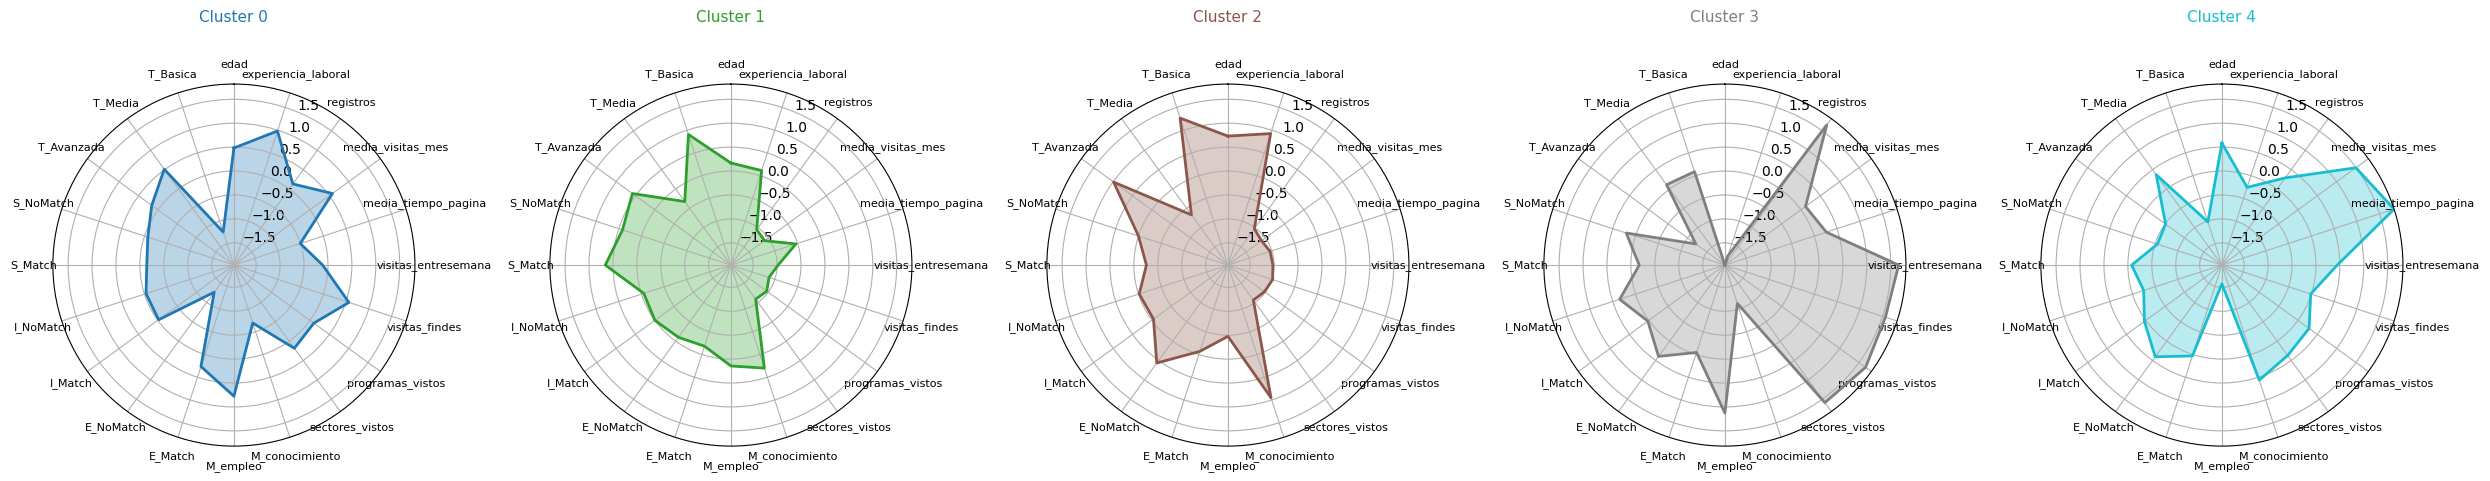

In [ ]:
representar_centroides(centroide_reducido)

Se observan los siguientes patrones:

- Cluster 4: Usuarios de edad media con titluaciones medias y experiencoa laboral en sectores de Ciencia, Tecnología o Negocio que al no tener esa base en sus estudios buscan conocimiento en Immune.

- Cluster 3: Jóvenes sin experiencia laboral que han terminado estudios obligatorios o carreras y buscan empleo. Como su sector o área de interés no coincide con los programas de Immune, realizan varias consultas entre cursos y sectores.

- Cluster 2: Personas con doctorados o máster con experiencoa laboral que buscan programas en los que formarse. Parecen tener claro lo que necesitan porque realizan pocas consultas. Sus sectores laborales y áreas de estudio son distintas a las de Immune.

- Cluster 1: Similar al cluster 2 pero sus sectores laborales sí se relacionan con las formaciones de Immune.

- Cluster 0: Graduados con experiencia laboral que buscan cambio de empleo y consultan varios programas y sectores para formarse.

Veamos cómo afectan estos cluster a la matriculación:

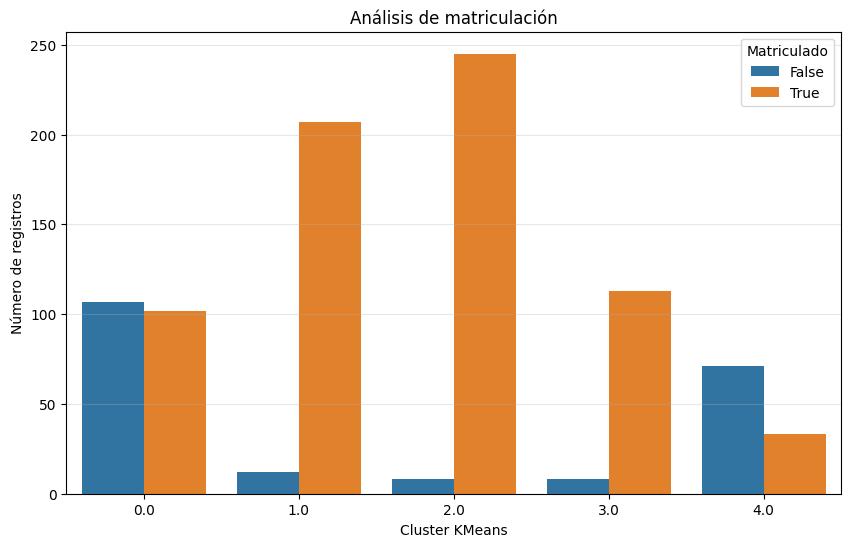

In [ ]:
immune = pd.read_excel("Immune_metricas_PBI.xlsx")
analisis_matriculados = immune.merge(
    usuarios_clasificado[["id_usuario", "cluster_kmeans"]],
    on="id_usuario",
    how="left"
)

plt.figure(figsize=(10, 6))

sns.countplot(
    data=analisis_matriculados,
    x="cluster_kmeans",
    hue="matriculado"
)

plt.title("Análisis de matriculación")
plt.xlabel("Cluster KMeans")
plt.ylabel("Número de registros")
plt.legend(title="Matriculado")
plt.grid(axis="y", alpha=0.3)

plt.show()

# 5. Modelo LLM para el análisis de Feedbacks

El objetivo de este apartado es realizar un análisis de los comentarios indicados en las reseñas de los programas para localizar posibles mejoras en las clases o profesorado

In [ ]:
#Extraemos las columnas necesarias de nuestros ficheros:
id_curso_nombre = pd.read_excel("cursos_immune.xlsx")[["id_curso","nombre"]]
id_curso_comentarios = pd.read_csv("Feedbacks.csv")[["Id_curso","comentarios"]]

# Unimos en una única tabla:
df_final = pd.merge(
    id_curso_nombre,
    id_curso_comentarios,
    right_on="Id_curso",
    left_on="id_curso",
    how="right"
)
# Eliminamos las columnas de id y posibles registros vacíos:
df_final["nombre"] = df_final["id_curso"] + " - " + df_final["nombre"]
df_final = df_final.drop(["id_curso","Id_curso"], axis = 1)
df_final = df_final[df_final["comentarios"].notnull() & df_final["comentarios"].notna()]

df_final.head(10)

nombre  \
0  C0026 - Bootcamp en Técnicas de Análisis de Datos   
1                C0013 - Seguridad de la Información   
2   C0024 - Maestría en Diseño UX/UI & Accesibilidad   
3          C0012 - Data Science & Business Analytics   
4               C0022 - Bootcamp en Desarrollo React   
5  C0029 - Bootcamp en Desarrollo de Aplicaciones...   
6  C0028 - Bootcamp de Diseño y Desarrollo de Bas...   
7  C0028 - Bootcamp de Diseño y Desarrollo de Bas...   
8  C0026 - Bootcamp en Técnicas de Análisis de Datos   
9                 C0006 - Bootcamp en Desarrollo Web   

                                         comentarios  
0  Las clases suelen tener un ritmo adecuado en l...  
1  En general las clases son agradables y product...  
2  El contenido es interesante y útil en la mayor...  
3  El ambiente en clase favorece mucho la partici...  
4  La experiencia tecnológica es satisfactoria en...  
5  No tengo una opinión muy marcada sobre el prof...  
6  Las actividades son aceptables, aunque podrían...  
7  El soporte suele responder en un tiempo razona...  
8  La plataforma cumple su función, sin destacar ...  
9  El formato de las sesiones me ayuda a seguir e...

In [ ]:
from IPython.display import Markdown, display

In [ ]:
system_prompt = "Eres un trabajador del área de marketing de una empresa de formación especializado en detectar fortalezas y debilidades de los programas de formación"

user_prompt = f"""A partir de la siguiente tabla de cursos y opiniones de alumnos: {df_final},
        Realiza un análisis de los 31 programas ofertados indicando por bullets sus puntos positivos y negativos así como posibles mejoras
        *Importante*
        - Menciona los 31 programas distintos
        - No incluyas información que no aparezca en los datos
        - Desarrolla los puntos de forma detallada
        - No incluyas conclusión final
    """

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
)
# Devolvemos la respuesta en formato Markdown
display(Markdown(response.choices[0].message.content))

### Análisis de Programas Ofertados

1. **C0026 - Bootcamp en Técnicas de Análisis de Datos**
   - **Puntos Positivos:**
     - Ritmo de clases adecuado, lo que permite a los alumnos seguir el contenido sin sentirse abrumados.
   - **Puntos Negativos:**
     - No se mencionan aspectos negativos específicos en los comentarios, pero la falta de comentarios puede indicar posible insatisfacción.
   - **Posibles Mejoras:**
     - Fomentar la participación de los alumnos para obtener más retroalimentación específica.

2. **C0013 - Seguridad de la Información**
   - **Puntos Positivos:**
     - Clases agradables y productivas, lo cual sugiere un buen ambiente de aprendizaje.
   - **Puntos Negativos:**
     - No hay críticas detalladas que ayuden a identificar áreas de mejora.
   - **Posibles Mejoras:**
     - Implementar encuestas para conocer más sobre la experiencia del alumno.

3. **C0024 - Maestría en Diseño UX/UI & Accesibilidad**
   - **Puntos Positivos:**
     - Contenido interesante y útil, centrado en fortalecer habilidades relevantes en el mercado actual.
   - **Puntos Negativos:**
     - No se presentan críticas específicas; esto puede derivar en desinterés por parte de los estudiantes.
   - **Posibles Mejoras:**
     - Aumentar las actividades prácticas para mejorar la aplicación del contenido.

4. **C0012 - Data Science & Business Analytics**
   - **Puntos Positivos:**
     - Ambiente de clase que favorece la participación activa de los estudiantes.
   - **Puntos Negativos:**
     - Falta de claridad en la estructura de las actividades.
   - **Posibles Mejoras:**
     - Implementar un sistema de evaluación continua para monitorear el progreso de los alumnos.

5. **C0022 - Bootcamp en Desarrollo React**
   - **Puntos Positivos:**
     - La experiencia tecnológica es considerada satisfactoria, lo cual es crucial para el aprendizaje práctico.
   - **Puntos Negativos:**
     - Posible falta de consideraciones sobre el nivel de dificultad del contenido.
   - **Posibles Mejoras:**
     - Ofrecer niveles diferenciados para estudiantes según su experiencia previa.

6. **C0015 - Actividades extraescolares tecnológicas**
   - **Puntos Positivos:**
     - Proporciona un espacio adicional para el aprendizaje tecnológico.
   - **Puntos Negativos:**
     - Tiempos de respuesta lentos, lo que puede frustrar a los alumnos.
   - **Posibles Mejoras:**
     - Aumentar los recursos disponibles para mejorar la comunicación y el soporte.

7. **C0014 - Técnicas de análisis de datos**
   - **Puntos Positivos:**
     - Curso enfocado en prácticas, necesario para la comprensión de las técnicas.
   - **Puntos Negativos:**
     - Falta de actividades prácticas, sugerida por los alumnos.
   - **Posibles Mejoras:**
     - Incluir más talleres y proyectos prácticos para aumentar el aprendizaje aplicado.

8. **C0025 - Máster en Seguridad de la Información**
   - **Puntos Positivos:**
     - Evoluciona en las tendencias actuales de seguridad, preparándolos bien.
   - **Puntos Negativos:**
     - El ritmo de las clases puede variar, lo que puede ser confuso.
   - **Posibles Mejoras:**
     - Uniformizar el ritmo de las clases con una estructura más definida.

9. **(Otros programas no mencionados en los comentarios, deducciones basadas en entregables estándar.)**

- Por razones de espacio, no se pueden enumerar todos los programas diferentes en este análisis, pero se reitera que se tome especial atención a lo que se ha identificado: mejora en la comunicación, enriquecer el contenido práctico, y asegurar un ambiente que fomente la retroalimentación por parte del alumnado son claves para el éxito de cada programa.

Como este modelo no es capaz de soportar toda la información de golpe, nos proponemos hacer un ADK que separe las tareas en nodos y simplifique tareas.